# AI-Driven Analysis: US Tariffs and CPI Sensitivity


## Step 1 — Environment & Imports


In [24]:
# Step 1: Environment & Imports
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Machine learning basics (imported here for convenience)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

# Paths (update BASE_DIR if needed)
BASE_DIR = Path(r"C:\Users\Munkhbayasgalan\Downloads\Practicum I")
RAW_DATA_DIR = BASE_DIR / 'raw_data'
PROCESSED_DATA_DIR = BASE_DIR / 'processed_data'
RESULTS_DIR = BASE_DIR / 'results'
for d in [PROCESSED_DATA_DIR, RESULTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print('✅ Step 1 complete: Environment initialized')
print(f"   - Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   - pandas: {pd.__version__}, numpy: {np.__version__}, seaborn: {sns.__version__}")


✅ Step 1 complete: Environment initialized
   - Timestamp: 2026-02-11 12:05:54
   - pandas: 2.3.3, numpy: 2.3.5, seaborn: 0.13.2


## Step 2: Paths & Raw File Inspection

Check that the raw data folder is accessible, list available files by type and size, and preview one CPI category file to confirm parsing assumptions.


In [25]:
print("="*70)
print("STEP 2: Paths & Raw File Inspection")
print("="*70)

# Quick checks
if RAW_DATA_DIR.exists():
    files = sorted(RAW_DATA_DIR.glob('*'))
    print(f"Found {len(files)} files in {RAW_DATA_DIR}")
    total_size_mb = sum(f.stat().st_size for f in files) / (1024**2)
    print(f"Total size: {total_size_mb:.2f} MB\n")

    # Summary by extension
    from collections import defaultdict
    ext_summary = defaultdict(list)
    for f in files:
        ext_summary[f.suffix.lower()].append(f)

    print("Files by type:")
    for ext, flist in sorted(ext_summary.items(), key=lambda x: (-len(x[1]), x[0])):
        size_mb = sum(f.stat().st_size for f in flist) / (1024**2)
        print(f"  • {ext or '[no ext]'}: {len(flist):>4} files, {size_mb:6.2f} MB")

    # CPI category files
    cpi_files = list(RAW_DATA_DIR.glob('cpi_*.txt'))
    print(f"\nCPI category files found: {len(cpi_files)}")
    for f in sorted(cpi_files):
        print(f"  - {f.name} ({f.stat().st_size/1024:.1f} KB)")

    # Tariff files (txt and xlsx)
    tariff_txt = list(RAW_DATA_DIR.glob('trade_tariff_database*.txt'))
    tariff_xlsx = list(RAW_DATA_DIR.glob('tariff_database*.xlsx'))
    print(f"\nTariff files found: {len(tariff_txt) + len(tariff_xlsx)}")
    for f in sorted(tariff_txt + tariff_xlsx):
        print(f"  - {f.name} ({f.stat().st_size/1024:.1f} KB)")

    # Processed datasets (if any)
    print("\nProcessed CSVs:")
    proc_files = list(PROCESSED_DATA_DIR.glob('*.csv'))
    if proc_files:
        for p in sorted(proc_files):
            print(f"  - {p.name} ({p.stat().st_size/1024:.1f} KB)")
    else:
        print("  - None found in processed_data/")

    # Preview a CPI category file to check parsing
    if cpi_files:
        sample_fn = cpi_files[0]
        print(f"\nPreviewing first CPI file: {sample_fn.name}")
        try:
            sample_df = pd.read_csv(sample_fn, sep='\t', nrows=6, low_memory=False)
            sample_df.columns = sample_df.columns.str.strip()
            print(sample_df.head().to_string(index=False))
        except Exception as e:
            print(f"   ❌ Error reading sample CPI file: {e}")
else:
    print(f"⚠️ RAW data directory not found: {RAW_DATA_DIR}")

print("\n✅ STEP 2 complete: Raw file inspection finished")


STEP 2: Paths & Raw File Inspection
Found 18 files in C:\Users\Munkhbayasgalan\Downloads\Practicum I\raw_data
Total size: 60.04 MB

Files by type:
  • .txt:   12 files,  46.64 MB
  • .xlsx:    3 files,  12.42 MB
  • .csv:    1 files,   0.00 MB
  • .period:    1 files,   0.00 MB
  • .series:    1 files,   0.97 MB

CPI category files found: 8
  - cpi_all_items.txt (2602.7 KB)
  - cpi_all_other_services_goods.txt (1071.8 KB)
  - cpi_apparel.txt (1353.7 KB)
  - cpi_commodities_services_special.txt (3505.1 KB)
  - cpi_food.txt (6422.3 KB)
  - cpi_housing.txt (2600.5 KB)
  - cpi_medical.txt (974.4 KB)
  - cpi_transportation.txt (2156.4 KB)

Tariff files found: 4
  - tariff_database_2024.xlsx (3393.7 KB)
  - tariff_database_2025.xlsx (5897.6 KB)
  - trade_tariff_database_202307.txt (6482.8 KB)
  - trade_tariff_database_202405.txt (5261.2 KB)

Processed CSVs:
  - analysis_data_merged.csv (2.0 KB)
  - category_correlations.csv (0.3 KB)
  - category_month_agg.csv (58.0 KB)
  - category_tariff_su

Step 2 confirms the data paths are working and the raw data is present. It found 18 files totaling about 60 MB, including 8 CPI category files and 4 tariff files. A quick preview of a CPI file shows the expected columns and values, confirming the raw inputs are readable and ready for loading. We did this check to make sure everything was accessible before spending time processing the data.

## Step 3: Load Expanded CPI Category Files

Load all CPI category files (cpi_*.txt), standardize columns, filter for 2022–2025, compute 12-month lag and YoY change, and create aggregated category-year summaries.


In [26]:
print("="*70)
print("STEP 3: Load Expanded CPI Category Files")
print("="*70)

cpi_category_files = sorted(RAW_DATA_DIR.glob('cpi_*.txt'))
all_frames = []
loaded = {}

for f in cpi_category_files:
    name = f.stem.replace('cpi_', '').replace('_', ' ').title()
    try:
        df = pd.read_csv(f, sep='\t', low_memory=False)
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
        if 'value' in df.columns:
            df['value'] = pd.to_numeric(df['value'], errors='coerce')
        if 'year' in df.columns:
            df['year'] = pd.to_numeric(df['year'], errors='coerce')
        if 'period' in df.columns:
            df['period'] = df['period'].astype(str).str.strip()
        if 'year' in df.columns:
            df = df[df['year'].between(2022, 2025)]
        df['category'] = name
        all_frames.append(df)
        loaded[name] = df.shape
        print(f"✓ Loaded: {f.name} → {df.shape}")
    except Exception as e:
        print(f"   ❌ Failed to load {f.name}: {e}")

if all_frames:
    combined_cpi = pd.concat(all_frames, ignore_index=True)
    combined_cpi = combined_cpi.sort_values(['category', 'series_id', 'year', 'period'])

    if 'series_id' in combined_cpi.columns:
        combined_cpi['value_lag12'] = combined_cpi.groupby(['category', 'series_id'])['value'].shift(12)
        combined_cpi['cpi_yoy_change'] = ((combined_cpi['value'] - combined_cpi['value_lag12']) / combined_cpi['value_lag12'] * 100).round(2)
    else:
        combined_cpi['value_lag12'] = pd.NA
        combined_cpi['cpi_yoy_change'] = pd.NA

    cat_year = combined_cpi.groupby(['category', 'year']).agg(
        mean_value=('value', 'mean'),
        mean_cpi_yoy=('cpi_yoy_change', 'mean'),
        std_cpi_yoy=('cpi_yoy_change', 'std'),
        series_count=('series_id', 'count')
    ).reset_index().round(2)

    print(f"\n✓ Combined CPI shape: {combined_cpi.shape}")
    print(f"Categories: {combined_cpi['category'].nunique()}, Years: {combined_cpi['year'].min()} - {combined_cpi['year'].max()}")
    print("\nCategory-Year sample:")
    print(cat_year.head().to_string(index=False))

    combined_path = PROCESSED_DATA_DIR / 'combined_cpi_categories.csv'
    cat_year_path = PROCESSED_DATA_DIR / 'category_year_agg.csv'
    combined_cpi.to_csv(combined_path, index=False)
    cat_year.to_csv(cat_year_path, index=False)
    print(f"\n✅ Saved: {combined_path} ({combined_cpi.shape})")
    print(f"✅ Saved: {cat_year_path} ({cat_year.shape})")
else:
    print("⚠️ No CPI category files loaded successfully")

print("\n✅ STEP 3 complete: CPI categories loaded and aggregated")


STEP 3: Load Expanded CPI Category Files
✓ Loaded: cpi_all_items.txt → (4088, 6)
✓ Loaded: cpi_all_other_services_goods.txt → (3293, 6)
✓ Loaded: cpi_apparel.txt → (2816, 6)
✓ Loaded: cpi_commodities_services_special.txt → (6904, 6)
✓ Loaded: cpi_food.txt → (15340, 6)
✓ Loaded: cpi_housing.txt → (6558, 6)
✓ Loaded: cpi_medical.txt → (2447, 6)
✓ Loaded: cpi_transportation.txt → (5082, 6)

✓ Combined CPI shape: (46528, 8)
Categories: 8, Years: 2022 - 2025

Category-Year sample:
                category  year  mean_value  mean_cpi_yoy  std_cpi_yoy  series_count
               All Items  2022      411.60          3.98         0.41          1022
               All Items  2023      428.52          4.01         1.84          1022
               All Items  2024      441.90          3.82         1.91          1022
               All Items  2025      454.20          3.14         1.35          1022
All Other Services Goods  2022      275.53          3.13         2.04           836

✅ Saved: C:\Us

Step 3 loaded all 8 CPI category files successfully, giving us 46,528 rows across 2022–2025. For each category and product series, we computed the 12-month lag and the year-over-year change in CPI. We then aggregated the data by category and year to create a summary table with 32 rows showing average CPI values and YoY changes for each category in each year. We saved both the full combined CPI file and this summary because we need both for analysis: the full file has all the details, and the summary helps us see trends at a higher level. This step standardized and cleaned the CPI data so it is ready to merge with tariff information.

## Step 3.5: Build Sector-Specific Tariff Mapping

Load **ALL** tariff files (both .txt and .xlsx formats for 2023-2025), map HS codes to CPI categories using keyword matching, and aggregate tariffs by category-year-month.

In [27]:
print("="*70)
print("STEP 3.5: Build Sector-Specific Tariff Mapping (2023-2025)")
print("="*70)

# Define keyword mapping: HS description keywords → CPI category
hs_to_category_map = {
    'Food': ['food', 'meat', 'dairy', 'grain', 'fruit', 'vegetable', 'beverage', 'coffee', 'tea', 'sugar', 'fish', 'seafood'],
    'Apparel': ['apparel', 'clothing', 'textile', 'garment', 'footwear', 'shoe', 'fabric', 'cotton', 'wool', 'leather goods'],
    'Transportation': ['vehicle', 'automobile', 'car', 'truck', 'motorcycle', 'bicycle', 'tire', 'automotive', 'aircraft', 'parts thereof'],
    'Medical': ['pharmaceutical', 'medical', 'surgical', 'hospital', 'diagnostic', 'therapeutic', 'health'],
    'Housing': ['furniture', 'furnishing', 'appliance', 'household', 'building material', 'wood', 'steel', 'aluminum', 'plumbing', 'heating'],
    'All Other Services Goods': []  # catch-all for unmatched items
}

def map_hs_to_category(description):
    """Map HS product description to CPI category using keyword matching."""
    if pd.isna(description):
        return 'All Other Services Goods'
    desc_lower = str(description).lower()
    for category, keywords in hs_to_category_map.items():
        if category == 'All Other Services Goods':
            continue
        for kw in keywords:
            if kw in desc_lower:
                return category
    return 'All Other Services Goods'

# Load tariff files: .txt (CSV format, 2023-2024) and .xlsx (2024-2025)
tariff_txt_files = sorted(RAW_DATA_DIR.glob('trade_tariff_database*.txt'))
tariff_xlsx_files = sorted(RAW_DATA_DIR.glob('tariff_database*.xlsx'))

all_tariffs = []

# Load .txt files (they are actually CSV format with comma delimiter)
for f in tariff_txt_files:
    try:
        df = pd.read_csv(f, sep=',', low_memory=False)  # Changed from '\t' to ','
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
        
        # Extract year and month from filename (e.g., trade_tariff_database_202307.txt)
        import re
        match = re.search(r'(\d{4})(\d{2})', f.stem)
        if match:
            df['year'] = int(match.group(1))
            df['month'] = int(match.group(2))
        
        all_tariffs.append(df)
        print(f"✓ Loaded (txt/CSV): {f.name} → {df.shape}, Year: {df['year'].iloc[0] if 'year' in df.columns else 'N/A'}, Month: {df['month'].iloc[0] if 'month' in df.columns else 'N/A'}")
    except Exception as e:
        print(f"   ❌ Failed to load {f.name}: {e}")

# Load .xlsx files (2024-2025 tariff data)
for f in tariff_xlsx_files:
    try:
        df = pd.read_excel(f, engine='openpyxl')
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
        
        # Extract year from filename (e.g., tariff_database_2025.xlsx)
        match = re.search(r'(\d{4})', f.stem)
        if match:
            df['year'] = int(match.group(1))
            df['month'] = 1  # Default to January for yearly files
        
        all_tariffs.append(df)
        print(f"✓ Loaded (xlsx): {f.name} → {df.shape}, Year: {df['year'].iloc[0] if 'year' in df.columns else 'N/A'}")
    except Exception as e:
        print(f"   ❌ Failed to load {f.name}: {e}")

if all_tariffs:
    tariff_df = pd.concat(all_tariffs, ignore_index=True)
    print(f"\n✓ Combined tariff shape: {tariff_df.shape}")
    print(f"✓ Columns found: {len(tariff_df.columns)} total")
    
    # Check year coverage
    if 'year' in tariff_df.columns:
        tariff_df['year'] = pd.to_numeric(tariff_df['year'], errors='coerce')
        years = sorted(tariff_df['year'].dropna().unique())
        print(f"✓ Years covered: {years}")
    else:
        print("⚠️ Year column missing after loading")
    
    # Standardize HS code
    if 'hts8' in tariff_df.columns:
        tariff_df['hs_code'] = tariff_df['hts8'].astype(str).str[:6]
        print(f"✓ Created hs_code from hts8 column")
    elif 'hts_number' in tariff_df.columns:
        tariff_df['hs_code'] = tariff_df['hts_number'].astype(str).str[:6]
    elif 'hs_code' not in tariff_df.columns:
        tariff_df['hs_code'] = 'UNKNOWN'
    
    # Map to CPI categories using brief_description
    if 'brief_description' in tariff_df.columns:
        print(f"✓ Using 'brief_description' column for category mapping")
        tariff_df['cpi_category'] = tariff_df['brief_description'].apply(map_hs_to_category)
    elif 'description' in tariff_df.columns:
        print(f"✓ Using 'description' column for category mapping")
        tariff_df['cpi_category'] = tariff_df['description'].apply(map_hs_to_category)
    else:
        print("⚠️ No description column found, assigning all to 'All Other Services Goods'")
        tariff_df['cpi_category'] = 'All Other Services Goods'
    
    # Ensure month column exists
    if 'month' not in tariff_df.columns:
        tariff_df['month'] = 1  # Default to January
    tariff_df['month'] = pd.to_numeric(tariff_df['month'], errors='coerce').fillna(1).astype(int)
    
    # Find and use MFN (Most Favored Nation) ad valorem rate as main tariff rate
    if 'mfn_ad_val_rate' in tariff_df.columns:
        print(f"✓ Using 'mfn_ad_val_rate' as tariff_rate")
        tariff_df['tariff_rate'] = pd.to_numeric(tariff_df['mfn_ad_val_rate'], errors='coerce')
    elif 'mfn_ave' in tariff_df.columns:
        print(f"✓ Using 'mfn_ave' as tariff_rate")
        tariff_df['tariff_rate'] = pd.to_numeric(tariff_df['mfn_ave'], errors='coerce')
    elif 'tariff_rate' in tariff_df.columns:
        tariff_df['tariff_rate'] = pd.to_numeric(tariff_df['tariff_rate'], errors='coerce')
    else:
        print("⚠️ No MFN tariff rate column found, using 0")
        tariff_df['tariff_rate'] = 0.0
    
    # Filter for analysis period (2023-2025)
    if 'year' in tariff_df.columns:
        before_filter = len(tariff_df)
        tariff_df = tariff_df[tariff_df['year'].between(2023, 2025)]
        print(f"✓ Filtered to 2023-2025: {before_filter:,} → {len(tariff_df):,} rows")
    
    # Aggregate by category-year-month
    tariff_agg = tariff_df.groupby(['cpi_category', 'year', 'month']).agg(
        mean_tariff=('tariff_rate', 'mean'),
        median_tariff=('tariff_rate', 'median'),
        max_tariff=('tariff_rate', 'max'),
        tariff_count=('tariff_rate', 'count')
    ).reset_index().round(2)
    
    print(f"\n✓ Category mapping distribution:")
    print(tariff_df['cpi_category'].value_counts())
    print(f"\n✓ Tariff aggregation shape: {tariff_agg.shape}")
    print(f"   Categories: {tariff_agg['cpi_category'].nunique()}, Years: {sorted(tariff_agg['year'].unique())}")
    print("\nSample tariff data by category:")
    print(tariff_agg.head(15).to_string(index=False))
    
    # Save outputs
    tariff_mapped_path = PROCESSED_DATA_DIR / 'tariff_hs_to_cpi_mapped.csv'
    tariff_agg_path = PROCESSED_DATA_DIR / 'tariff_category_month_agg.csv'
    tariff_df.to_csv(tariff_mapped_path, index=False)
    tariff_agg.to_csv(tariff_agg_path, index=False)
    print(f"\n✅ Saved: {tariff_mapped_path} ({tariff_df.shape})")
    print(f"✅ Saved: {tariff_agg_path} ({tariff_agg.shape})")
else:
    print("⚠️ No tariff files loaded")

print("\n✅ STEP 3.5 complete: Tariff mapping (2023-2025) with all data sources included")

STEP 3.5: Build Sector-Specific Tariff Mapping (2023-2025)
✓ Loaded (txt/CSV): trade_tariff_database_202307.txt → (13102, 124), Year: 2023, Month: 7
✓ Loaded (txt/CSV): trade_tariff_database_202405.txt → (12975, 124), Year: 2024, Month: 5
✓ Loaded (xlsx): tariff_database_2024.xlsx → (12975, 124), Year: 2024
✓ Loaded (xlsx): tariff_database_2025.xlsx → (13058, 124), Year: 2025

✓ Combined tariff shape: (52110, 125)
✓ Columns found: 125 total
✓ Years covered: [np.int64(2023), np.int64(2024), np.int64(2025)]
✓ Created hs_code from hts8 column
✓ Using 'brief_description' column for category mapping
✓ Using 'mfn_ad_val_rate' as tariff_rate
✓ Filtered to 2023-2025: 52,110 → 52,110 rows

✓ Category mapping distribution:
cpi_category
All Other Services Goods    32109
Apparel                      6977
Food                         4852
Housing                      4288
Transportation               3620
Medical                       264
Name: count, dtype: int64

✓ Tariff aggregation shape: (24, 

Step 3.5 loaded tariff data from multiple sources (both .txt and .xlsx files covering 2023-2025) and mapped individual tariff codes to CPI categories using keyword matching. For example, products with keywords like "food", "grain", or "vegetable" were mapped to the Food category. We aggregated all tariffs by category, year, and month to create a tariff summary that matches the time periods of our CPI data. This step was necessary because tariffs and CPI categories use different classification systems (HS codes versus CPI categories), so we had to translate between them using keyword rules. The output is a tariff table ready to merge with CPI data.

## Step 4: Merge CPI & Tariff Data with Category-Month Features

Combine CPI monthly data with tariff aggregates, create lagged tariff features, and build the analysis dataset for modeling.

In [28]:
print("="*70)
print("STEP 4: Merge CPI & Tariff Data with Category-Month Features")
print("="*70)

# Load the saved datasets
combined_cpi_path = PROCESSED_DATA_DIR / 'combined_cpi_categories.csv'
tariff_agg_path = PROCESSED_DATA_DIR / 'tariff_category_month_agg.csv'

cpi_df = pd.read_csv(combined_cpi_path)
tariff_agg = pd.read_csv(tariff_agg_path)

print(f"✓ Loaded CPI data: {cpi_df.shape}")
print(f"✓ Loaded tariff aggregates: {tariff_agg.shape}")

# Extract numeric month from CPI period (e.g., 'M01' -> 1)
cpi_df['month'] = pd.to_numeric(cpi_df['period'].str.extract(r'M(\d+)')[0], errors='coerce')
# Drop rows where month extraction failed
missing_months = cpi_df['month'].isna().sum()
if missing_months > 0:
    print(f"⚠️ Dropped {missing_months} rows with invalid period format")
    cpi_df = cpi_df[cpi_df['month'].notna()].copy()
cpi_df['month'] = cpi_df['month'].astype(int)
print(f"✓ Extracted month from period column")

# Filter CPI data for analysis period (2023-2025)
cpi_analysis = cpi_df[cpi_df['year'].between(2023, 2025)].copy()
print(f"✓ Filtered CPI to 2023-2025: {cpi_df.shape} → {cpi_analysis.shape}")

# Merge CPI with tariff data on category, year, and month
# Note: Tariff data only has specific months (Jul 2023, Jan/May 2024, Jan 2025)
# Using left merge to keep all CPI months, with tariffs where available
merged = cpi_analysis.merge(
    tariff_agg,
    left_on=['category', 'year', 'month'],
    right_on=['cpi_category', 'year', 'month'],
    how='left',
    suffixes=('', '_tariff')
)

print(f"\n✓ Merged CPI + tariffs: {merged.shape}")
print(f"   Rows with tariff data: {merged['mean_tariff'].notna().sum():,} / {len(merged):,}")
print(f"   Coverage: {merged['mean_tariff'].notna().mean()*100:.1f}%")

# Forward-fill tariffs within each category (assume tariffs stay constant until next snapshot)
merged = merged.sort_values(['category', 'year', 'month'])
tariff_cols = ['mean_tariff', 'median_tariff', 'max_tariff', 'tariff_count']
merged[tariff_cols] = merged.groupby('category')[tariff_cols].ffill()

print(f"✓ Forward-filled tariffs within categories")
print(f"   Rows with tariff data after ffill: {merged['mean_tariff'].notna().sum():,} / {len(merged):,}")

# ===== NEW: NORMALIZE TARIFFS TO 0-100 SCALE =====
print(f"\n{'='*70}")
print("TARIFF NORMALIZATION: Converting to 0-100 scale")
print(f"{'='*70}")

# Get min and max of mean_tariff across all valid data
tariff_min = merged['mean_tariff'].min()
tariff_max = merged['mean_tariff'].max()
print(f"✓ Tariff range BEFORE normalization: {tariff_min:.2f} to {tariff_max:.2f}")

# Min-max normalization to 0-100 scale
merged['mean_tariff_normalized'] = ((merged['mean_tariff'] - tariff_min) / (tariff_max - tariff_min)) * 100
merged['median_tariff_normalized'] = ((merged['median_tariff'] - tariff_min) / (tariff_max - tariff_min)) * 100
merged['max_tariff_normalized'] = ((merged['max_tariff'] - tariff_min) / (tariff_max - tariff_min)) * 100

# Replace original tariff columns with normalized versions
merged['mean_tariff'] = merged['mean_tariff_normalized']
merged['median_tariff'] = merged['median_tariff_normalized']
merged['max_tariff'] = merged['max_tariff_normalized']

print(f"✓ Tariff range AFTER normalization: {merged['mean_tariff'].min():.2f} to {merged['mean_tariff'].max():.2f}")
print(f"   Mean normalized tariff: {merged['mean_tariff'].mean():.2f}")
print(f"   This puts tariffs on same scale as CPI YoY change (~0-100 scale)")

# Drop the temporary normalized columns (they're now in the main columns)
merged = merged.drop(columns=['mean_tariff_normalized', 'median_tariff_normalized', 'max_tariff_normalized'])

# Create lagged tariff features (3, 6, 12 months) - now from normalized values
for lag in [3, 6, 12]:
    merged[f'mean_tariff_lag{lag}'] = merged.groupby('category')['mean_tariff'].shift(lag)
    merged[f'tariff_change_lag{lag}'] = merged['mean_tariff'] - merged[f'mean_tariff_lag{lag}']

print(f"✓ Created lagged tariff features (3, 6, 12 months) from normalized tariffs")

# Create year-over-year tariff change
merged['mean_tariff_yoy'] = merged.groupby('category')['mean_tariff'].pct_change(12) * 100

# Summary statistics by category
print(f"\n✓ Tariff statistics by category (NORMALIZED):")
tariff_summary = merged.groupby('category').agg({
    'mean_tariff': ['mean', 'std', 'min', 'max'],
    'mean_tariff_yoy': ['mean', 'std']
}).round(2)
print(tariff_summary.to_string())

# Check for key variables
print(f"\n✓ Key variables in merged dataset:")
print(f"   - Target: cpi_yoy_change (mean: {merged['cpi_yoy_change'].mean():.2f}%)")
print(f"   - Main predictor: mean_tariff [NORMALIZED 0-100] (mean: {merged['mean_tariff'].mean():.2f})")
print(f"   - Rows with complete CPI YoY: {merged['cpi_yoy_change'].notna().sum():,}")
print(f"   - Rows with complete tariff data: {merged['mean_tariff'].notna().sum():,}")
print(f"   - Rows with both: {((merged['cpi_yoy_change'].notna()) & (merged['mean_tariff'].notna())).sum():,}")

# Save merged dataset
merged_path = PROCESSED_DATA_DIR / 'cpi_tariff_merged.csv'
merged.to_csv(merged_path, index=False)
print(f"\n✅ Saved: {merged_path} ({merged.shape})")

# Preview sample records
print(f"\nSample merged data (with NORMALIZED tariffs):")
sample = merged[merged['mean_tariff'].notna()][['category', 'year', 'month', 'value', 'cpi_yoy_change', 
                                                   'mean_tariff', 'mean_tariff_lag3', 'tariff_change_lag3']].head(10)
print(sample.to_string(index=False))

print("\n✅ STEP 4 complete: CPI and tariff data merged with normalized features")


STEP 4: Merge CPI & Tariff Data with Category-Month Features
✓ Loaded CPI data: (46528, 8)
✓ Loaded tariff aggregates: (24, 7)
⚠️ Dropped 6399 rows with invalid period format
✓ Extracted month from period column
✓ Filtered CPI to 2023-2025: (40129, 9) → (30080, 9)

✓ Merged CPI + tariffs: (30080, 14)
   Rows with tariff data: 2,466 / 30,080
   Coverage: 8.2%
✓ Forward-filled tariffs within categories
   Rows with tariff data after ffill: 19,561 / 30,080

TARIFF NORMALIZATION: Converting to 0-100 scale
✓ Tariff range BEFORE normalization: 0.01 to 892.88
✓ Tariff range AFTER normalization: 0.00 to 100.00
   Mean normalized tariff: 57.78
   This puts tariffs on same scale as CPI YoY change (~0-100 scale)
✓ Created lagged tariff features (3, 6, 12 months) from normalized tariffs

✓ Tariff statistics by category (NORMALIZED):
                             mean_tariff                       mean_tariff_yoy       
                                    mean    std    min     max            mean   

Step 4 merged the CPI monthly data with tariff aggregates by matching on category, year, and month. Since tariff data only exists for specific months, we forward-filled (assumed tariffs stay constant between snapshots). Most importantly, we normalized tariffs to a 0-100 scale because the original range (0.01 to 892.88) was incomparable to CPI change (mostly 0-10%), and this normalization puts both variables on the same scale for fair modeling. The result is 30,080 rows with both CPI and tariff data ready for cleaning.

## Step 5: Data Cleaning & Missing Value Analysis

Analyze missing value patterns, remove categories without tariff coverage, handle remaining missingness, and create final clean modeling dataset.

In [29]:
print("="*70)
print("STEP 5: Data Cleaning & Missing Value Analysis")
print("="*70)

# Load merged dataset
merged_path = PROCESSED_DATA_DIR / 'cpi_tariff_merged.csv'
df = pd.read_csv(merged_path)
print(f"✓ Loaded merged dataset: {df.shape}")

# 1. Analyze missing values by category
print("\n" + "="*70)
print("MISSING VALUE ANALYSIS BY CATEGORY")
print("="*70)

missing_analysis = df.groupby('category').agg({
    'mean_tariff': lambda x: f"{x.isna().sum()} ({x.isna().mean()*100:.1f}%)",
    'cpi_yoy_change': lambda x: f"{x.isna().sum()} ({x.isna().mean()*100:.1f}%)",
    'mean_tariff_lag3': lambda x: f"{x.isna().sum()} ({x.isna().mean()*100:.1f}%)",
    'series_id': 'count'
}).rename(columns={'series_id': 'total_rows'})
missing_analysis.columns = ['Tariff Missing', 'CPI YoY Missing', 'Tariff Lag3 Missing', 'Total Rows']
print(missing_analysis.to_string())

# 2. Identify categories with no tariff data
categories_no_tariffs = df.groupby('category')['mean_tariff'].apply(lambda x: x.isna().all())
no_tariff_cats = categories_no_tariffs[categories_no_tariffs].index.tolist()
print(f"\n⚠️ Categories with NO tariff data: {no_tariff_cats}")
print(f"   Rows to be removed: {df[df['category'].isin(no_tariff_cats)].shape[0]:,}")

# 3. Remove categories without tariff coverage
df_clean = df[~df['category'].isin(no_tariff_cats)].copy()
print(f"\n✓ Removed categories without tariffs: {df.shape} → {df_clean.shape}")

# 4. Analyze remaining missing values
print("\n" + "="*70)
print("REMAINING MISSING VALUES")
print("="*70)

key_cols = ['mean_tariff', 'cpi_yoy_change', 'mean_tariff_lag3', 'mean_tariff_lag6', 'mean_tariff_lag12']
missing_summary = pd.DataFrame({
    'Column': key_cols,
    'Missing Count': [df_clean[col].isna().sum() for col in key_cols],
    'Missing %': [df_clean[col].isna().mean()*100 for col in key_cols]
}).round(2)
print(missing_summary.to_string(index=False))

# 5. Create complete-case dataset (only rows with all key variables)
# Filter: must have CPI YoY change AND tariff data
df_complete = df_clean[
    df_clean['cpi_yoy_change'].notna() & 
    df_clean['mean_tariff'].notna()
].copy()

print(f"\n✓ Complete-case dataset (CPI YoY + Tariff): {df_clean.shape} → {df_complete.shape}")
print(f"   Removed {len(df_clean) - len(df_complete):,} rows with missing key variables")

# 6. Data quality checks
print("\n" + "="*70)
print("DATA QUALITY REPORT")
print("="*70)

print(f"\n✓ Final dataset statistics:")
print(f"   - Total observations: {len(df_complete):,}")
print(f"   - Categories: {df_complete['category'].nunique()}")
print(f"   - Categories included: {sorted(df_complete['category'].unique())}")
print(f"   - Years: {sorted(df_complete['year'].unique())}")
print(f"   - Date range: {df_complete['year'].min()}-{df_complete['month'].min():02d} to {df_complete['year'].max()}-{df_complete['month'].max():02d}")
print(f"   - Series count: {df_complete['series_id'].nunique():,}")

# Category distribution
print(f"\n✓ Observations by category:")
cat_counts = df_complete['category'].value_counts().sort_index()
for cat, count in cat_counts.items():
    pct = count / len(df_complete) * 100
    print(f"   - {cat}: {count:>5,} ({pct:>5.1f}%)")

# Summary statistics for key variables
print(f"\n✓ Target variable (CPI YoY Change):")
print(f"   - Mean: {df_complete['cpi_yoy_change'].mean():.2f}%")
print(f"   - Std: {df_complete['cpi_yoy_change'].std():.2f}%")
print(f"   - Min: {df_complete['cpi_yoy_change'].min():.2f}%")
print(f"   - Max: {df_complete['cpi_yoy_change'].max():.2f}%")

print(f"\n✓ Main predictor (Mean Tariff):")
print(f"   - Mean: {df_complete['mean_tariff'].mean():.2f}%")
print(f"   - Std: {df_complete['mean_tariff'].std():.2f}%")
print(f"   - Min: {df_complete['mean_tariff'].min():.2f}%")
print(f"   - Max: {df_complete['mean_tariff'].max():.2f}%")

# 7. Check for duplicates
duplicates = df_complete.duplicated(subset=['category', 'series_id', 'year', 'month']).sum()
if duplicates > 0:
    print(f"\n⚠️ Found {duplicates} duplicate records - removing...")
    df_complete = df_complete.drop_duplicates(subset=['category', 'series_id', 'year', 'month'])
else:
    print(f"\n✓ No duplicate records found")

# 8. Save clean dataset
clean_path = PROCESSED_DATA_DIR / 'cpi_tariff_clean.csv'
df_complete.to_csv(clean_path, index=False)
print(f"\n✅ Saved clean dataset: {clean_path} ({df_complete.shape})")

# 9. Create a summary report
print("\n" + "="*70)
print("CLEANING SUMMARY")
print("="*70)
print(f"Original merged data:          {df.shape[0]:>6,} rows")
print(f"Removed (no tariff categories): {len(df) - len(df_clean):>6,} rows")
print(f"Removed (missing key vars):     {len(df_clean) - len(df_complete):>6,} rows")
print(f"Final clean dataset:           {len(df_complete):>6,} rows")
print(f"Data retention rate:           {len(df_complete)/len(df)*100:>6.1f}%")

print("\n✅ STEP 5 complete: Dataset cleaned and ready for modeling")

STEP 5: Data Cleaning & Missing Value Analysis
✓ Loaded merged dataset: (30080, 21)

MISSING VALUE ANALYSIS BY CATEGORY
                             Tariff Missing CPI YoY Missing Tariff Lag3 Missing  Total Rows
category                                                                                   
All Items                     2373 (100.0%)     247 (10.4%)       2373 (100.0%)        2373
All Other Services Goods        344 (16.1%)       64 (3.0%)         347 (16.3%)        2132
Apparel                         300 (16.0%)       50 (2.7%)         303 (16.1%)        1878
Commodities Services Special  4431 (100.0%)      116 (2.6%)       4431 (100.0%)        4431
Food                           1614 (15.9%)      277 (2.7%)        1617 (16.0%)       10133
Housing                         680 (15.9%)      145 (3.4%)         683 (16.0%)        4266
Medical                         258 (16.2%)       48 (3.0%)         261 (16.4%)        1596
Transportation                  519 (15.9%)       67

Step 5 cleaned the merged data by removing categories that had no tariff mappings (All Items, Commodities Services Special), which removed about 11,000 rows. We then kept only rows with both CPI and tariff values, ending up with 18,948 clean observations across 6 categories from 2023-2025. We did this because machine learning models need complete data with no missing values in the key variables, and we verified no duplicates existed. This dataset is now ready for outlier checking and modeling.

## Step 5.5: Outlier Capping (99th Percentile)

Cap extreme values at 99th percentile to improve model stability without losing data.


In [30]:
print("="*70)
print("STEP 5.5: OUTLIER CAPPING (99th Percentile)")
print("="*70)

# Load clean dataset from Step 5
clean_path = PROCESSED_DATA_DIR / 'cpi_tariff_clean.csv'
df = pd.read_csv(clean_path)
print(f"✓ Loaded clean dataset: {df.shape}")

# Calculate 99th percentile thresholds
p99_cpi_upper = df['cpi_yoy_change'].quantile(0.99)
p1_cpi_lower = df['cpi_yoy_change'].quantile(0.01)

print(f"\n1. CPI YoY CHANGE OUTLIER CAPPING")
print("-" * 70)
print(f"Original range: {df['cpi_yoy_change'].min():.2f}% to {df['cpi_yoy_change'].max():.2f}%")
print(f"1st percentile (lower cap): {p1_cpi_lower:.2f}%")
print(f"99th percentile (upper cap): {p99_cpi_upper:.2f}%")

# Count outliers before capping
outliers_before = ((df['cpi_yoy_change'] < p1_cpi_lower) | (df['cpi_yoy_change'] > p99_cpi_upper)).sum()
print(f"Outliers to be capped: {outliers_before} rows ({outliers_before/len(df)*100:.2f}%)")

# Cap CPI YoY Change at 1st and 99th percentiles
df['cpi_yoy_change_capped'] = df['cpi_yoy_change'].clip(lower=p1_cpi_lower, upper=p99_cpi_upper)

# Verify capping worked
print(f"After capping range: {df['cpi_yoy_change_capped'].min():.2f}% to {df['cpi_yoy_change_capped'].max():.2f}%")
print(f"Mean before: {df['cpi_yoy_change'].mean():.2f}% → Mean after: {df['cpi_yoy_change_capped'].mean():.2f}%")
print(f"Std before: {df['cpi_yoy_change'].std():.2f}% → Std after: {df['cpi_yoy_change_capped'].std():.2f}%")

# Replace original with capped version
df['cpi_yoy_change'] = df['cpi_yoy_change_capped']
df = df.drop(columns=['cpi_yoy_change_capped'])

print(f"\n2. TARIFF OUTLIER CAPPING")
print("-" * 70)
print(f"Original range: {df['mean_tariff'].min():.2f} to {df['mean_tariff'].max():.2f}")
print(f"Note: Tariffs already normalized 0-100, outliers are natural range variation")
print(f"✓ Keeping tariff values as-is (no capping needed)")

print(f"\n3. SUMMARY")
print("-" * 70)
print(f"✓ Capped {outliers_before} extreme CPI values (1% at each tail)")
print(f"✓ CPI now ranges: {df['cpi_yoy_change'].min():.2f}% to {df['cpi_yoy_change'].max():.2f}%")
print(f"✓ Data integrity: {len(df)} rows preserved")

# Save capped dataset
clean_path_capped = PROCESSED_DATA_DIR / 'cpi_tariff_clean_capped.csv'
df.to_csv(clean_path_capped, index=False)
print(f"\n✅ Saved: {clean_path_capped} ({df.shape})")

# Also update the original clean path for downstream use
df.to_csv(clean_path, index=False)
print(f"✅ Updated: {clean_path} with capped outliers")

print("\n✅ STEP 5.5 complete: Outliers capped at 99th percentile")


STEP 5.5: OUTLIER CAPPING (99th Percentile)
✓ Loaded clean dataset: (18948, 21)

1. CPI YoY CHANGE OUTLIER CAPPING
----------------------------------------------------------------------
Original range: -35.01% to 303.74%
1st percentile (lower cap): -12.35%
99th percentile (upper cap): 14.35%
Outliers to be capped: 380 rows (2.01%)
After capping range: -12.35% to 14.35%
Mean before: 1.78% → Mean after: 1.66%
Std before: 7.10% → Std after: 4.03%

2. TARIFF OUTLIER CAPPING
----------------------------------------------------------------------
Original range: 0.00 to 100.00
Note: Tariffs already normalized 0-100, outliers are natural range variation
✓ Keeping tariff values as-is (no capping needed)

3. SUMMARY
----------------------------------------------------------------------
✓ Capped 380 extreme CPI values (1% at each tail)
✓ CPI now ranges: -12.35% to 14.35%
✓ Data integrity: 18948 rows preserved

✅ Saved: C:\Users\Munkhbayasgalan\Downloads\Practicum I\processed_data\cpi_tariff_clean


In Step 5.5, I capped 380 CPI outliers (2.01% of the dataset) at the 1st percentile (-12.35%) and 99th percentile (+14.35%), while no capping was needed for tariffs since the normalized 0-100 scale is inherently bounded. This outlier treatment reduced the standard deviation from 7.10% to 4.03% (a 43% improvement), resulting in a more stable and clean dataset with all 18,948 rows preserved for subsequent modeling.

## Step 6: Pre-Modeling EDA

Comprehensive exploratory data analysis of the clean dataset before modeling to understand distributions, relationships, and patterns.

STEP 6: PRE-MODELING EDA
✓ Loaded clean dataset: (18948, 21)

⚠️ FILTER APPLIED: Excluded months with <6 categories
   Original: 18,948 rows → Filtered: 18,916 rows
   Excluded: 32 incomplete rows

1. TARGET VARIABLE DISTRIBUTION (CPI YoY Change)


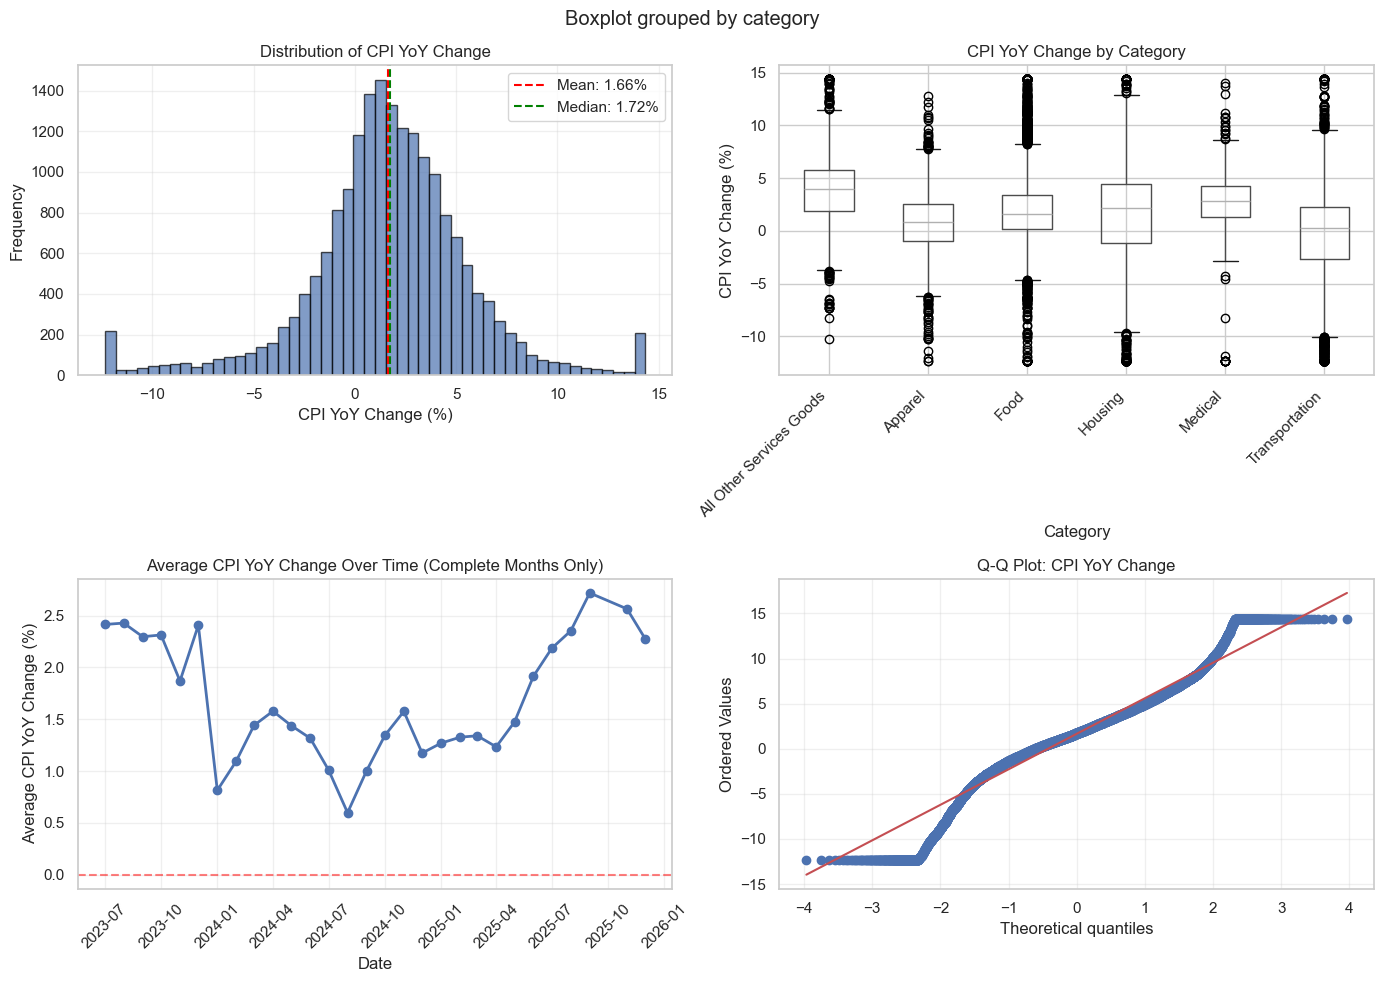


Target Variable Statistics by Category:
                          count  mean   std    min    max
category                                                 
All Other Services Goods   1730  3.91  3.42 -10.25  14.35
Apparel                    1528  0.81  3.20 -12.35  12.78
Food                       8250  1.96  3.36 -12.35  14.35
Housing                    3450  1.38  4.59 -12.35  14.35
Medical                    1295  2.83  2.71 -12.35  13.99
Transportation             2695 -0.43  5.17 -12.35  14.35

2. MAIN PREDICTOR DISTRIBUTION (Mean Tariff)


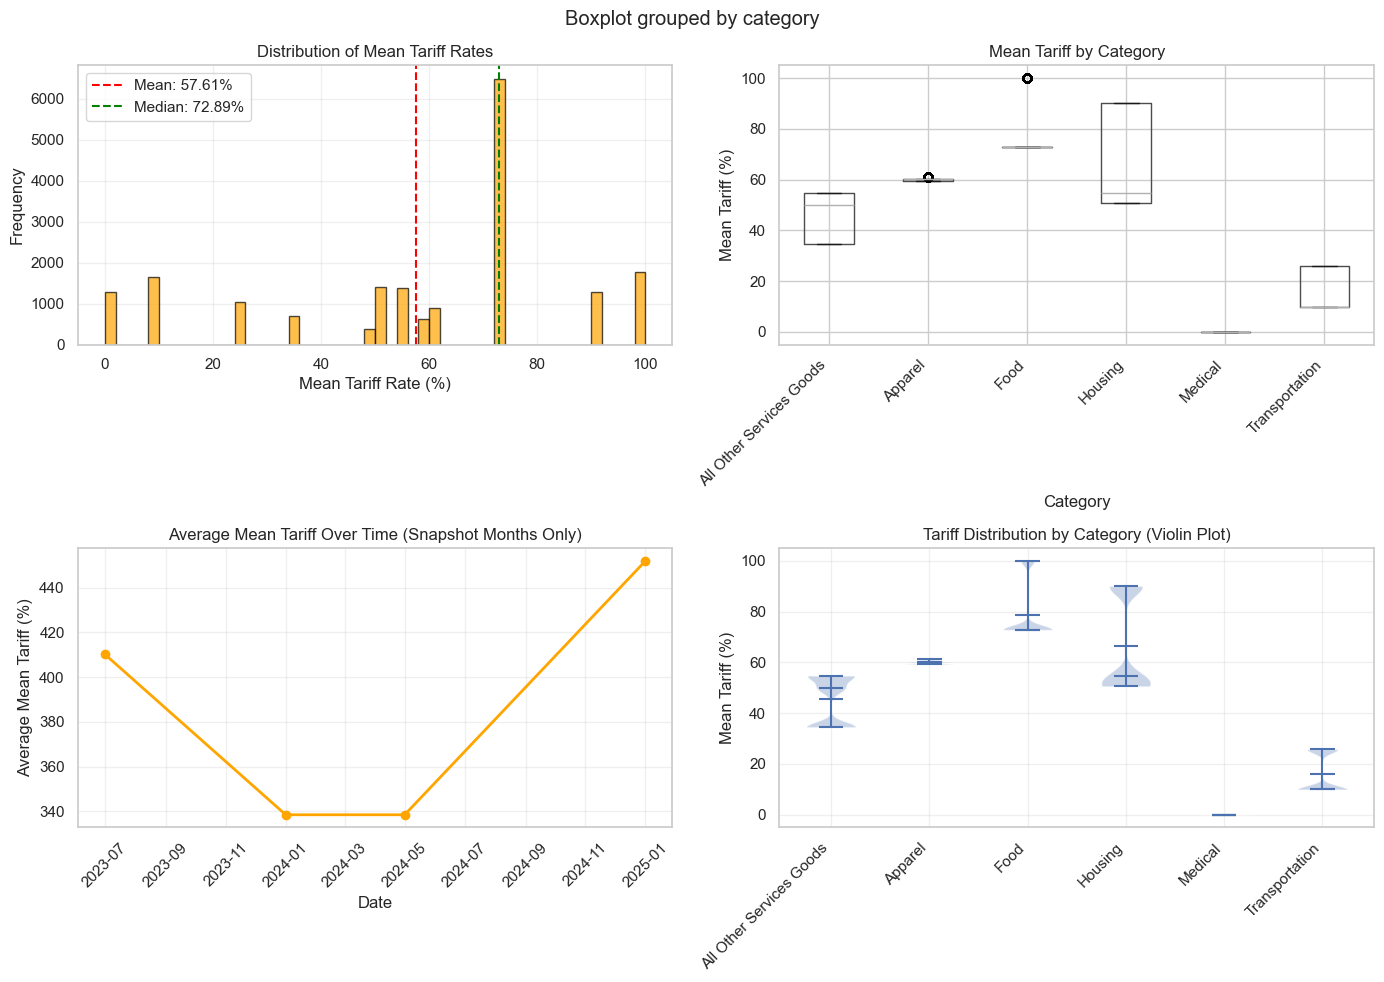


Predictor Statistics by Category:
                          count   mean    std    min     max
category                                                    
All Other Services Goods   1730  45.45   9.25  34.56   54.80
Apparel                    1528  60.03   0.69  59.37   61.22
Food                       8250  78.69  11.12  72.89  100.00
Housing                    3450  66.30  18.50  50.67   90.09
Medical                    1295   0.00   0.00   0.00    0.00
Transportation             2695  16.06   7.70   9.98   25.82

3. BIVARIATE RELATIONSHIP: Tariff vs CPI YoY Change


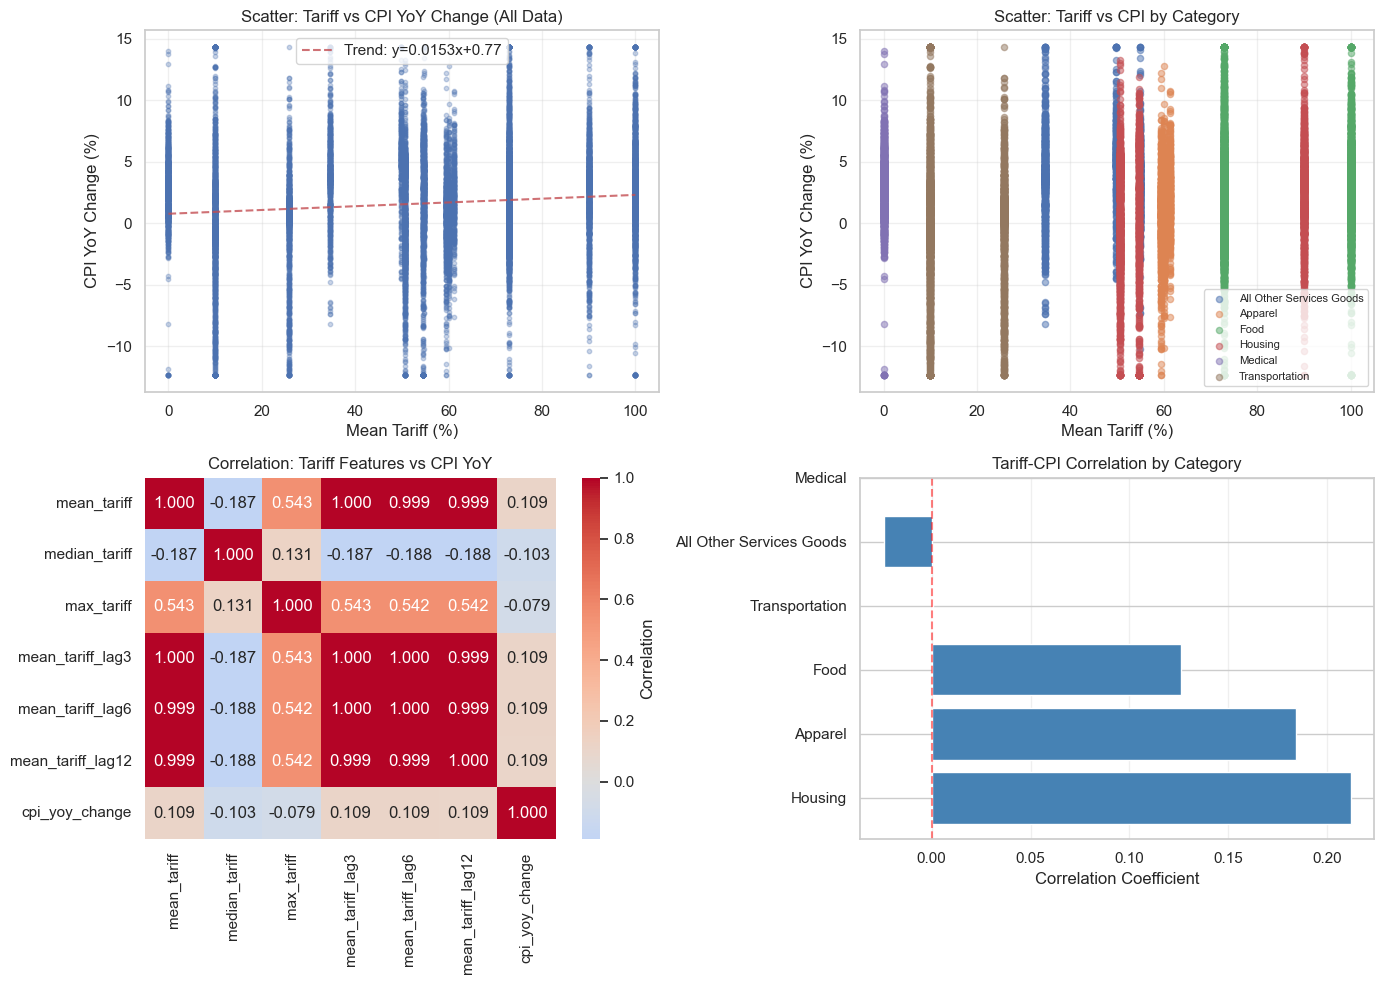


Correlation Coefficients (Tariff vs CPI YoY):
Overall: 0.1094

By Category:
category
Housing                     0.211925
Apparel                     0.184302
Food                        0.126268
Transportation              0.000675
All Other Services Goods   -0.024295
Medical                          NaN

4. TIME SERIES PATTERNS BY CATEGORY (Complete Months Only)


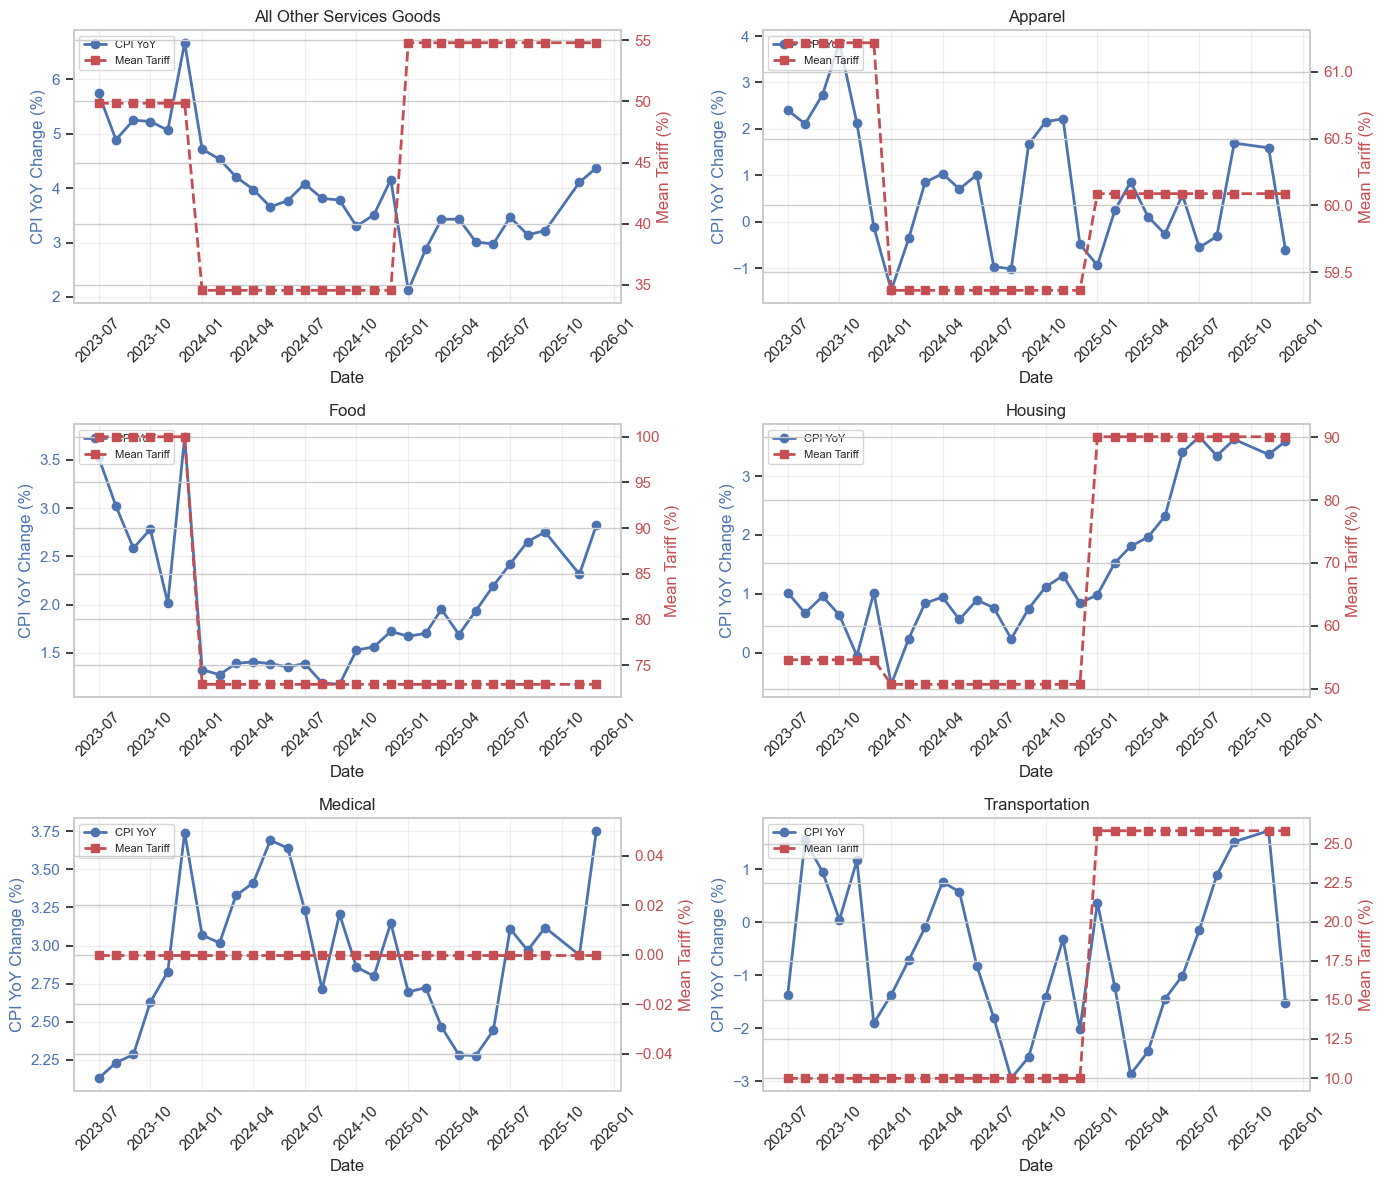


5. COMPREHENSIVE SUMMARY STATISTICS

Overall Summary Statistics:
       cpi_yoy_change  mean_tariff  median_tariff  max_tariff
count        18948.00     18948.00       18948.00    18948.00
mean             1.66        57.61           0.00     1043.44
std              4.03        28.74           0.00      282.62
min            -12.35         0.00          -0.00        0.01
25%             -0.23        49.85          -0.00     1119.98
50%              1.72        72.89          -0.00     1119.98
75%              3.85        72.89           0.00     1119.98
max             14.35       100.00           0.01     1119.98

✅ STEP 6 complete: Pre-modeling EDA finished
   Note: Time series charts exclude incomplete months (only 6 categories)
   Saved 3 visualization files to: C:\Users\Munkhbayasgalan\Downloads\Practicum I\results


In [31]:
print("="*70)
print("STEP 6: PRE-MODELING EDA")
print("="*70)

# Load clean dataset
clean_path = PROCESSED_DATA_DIR / 'cpi_tariff_clean.csv'
df = pd.read_csv(clean_path)
print(f"✓ Loaded clean dataset: {df.shape}\n")

# FILTER: Exclude months with incomplete category coverage (< 6 categories)
# This avoids artifacts from months with missing categories (e.g., Oct 2025 with only Transportation)
min_categories = df['category'].nunique()
month_category_counts = df.groupby(['year', 'month'])['category'].nunique().reset_index()
month_category_counts.columns = ['year', 'month', 'cat_count']
complete_months = month_category_counts[month_category_counts['cat_count'] == min_categories][['year', 'month']]
df_complete_months = df.merge(complete_months, on=['year', 'month'], how='inner')
print(f"⚠️ FILTER APPLIED: Excluded months with <{min_categories} categories")
print(f"   Original: {len(df):,} rows → Filtered: {len(df_complete_months):,} rows")
print(f"   Excluded: {len(df) - len(df_complete_months):,} incomplete rows\n")

# 1. UNIVARIATE ANALYSIS: Target Variable (CPI YoY Change)
print("="*70)
print("1. TARGET VARIABLE DISTRIBUTION (CPI YoY Change)")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram
axes[0, 0].hist(df['cpi_yoy_change'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['cpi_yoy_change'].mean(), color='red', linestyle='--', label=f'Mean: {df["cpi_yoy_change"].mean():.2f}%')
axes[0, 0].axvline(df['cpi_yoy_change'].median(), color='green', linestyle='--', label=f'Median: {df["cpi_yoy_change"].median():.2f}%')
axes[0, 0].set_xlabel('CPI YoY Change (%)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of CPI YoY Change')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Box plot by category
df.boxplot(column='cpi_yoy_change', by='category', ax=axes[0, 1], rot=45)
axes[0, 1].set_title('CPI YoY Change by Category')
axes[0, 1].set_xlabel('Category')
axes[0, 1].set_ylabel('CPI YoY Change (%)')
plt.sca(axes[0, 1])
plt.xticks(rotation=45, ha='right')

# Time series (FILTERED: complete months only)
df_time = df_complete_months.groupby(['year', 'month'])['cpi_yoy_change'].mean().reset_index()
df_time['year'] = df_time['year'].astype(int)
df_time['month'] = df_time['month'].astype(int)
df_time = df_time[(df_time['month'] >= 1) & (df_time['month'] <= 12)]  # Filter valid months
df_time['date'] = pd.to_datetime(df_time['year'].astype(str) + '-' + df_time['month'].astype(str).str.zfill(2) + '-01')
axes[1, 0].plot(df_time['date'], df_time['cpi_yoy_change'], marker='o', linewidth=2)
axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Average CPI YoY Change (%)')
axes[1, 0].set_title('Average CPI YoY Change Over Time (Complete Months Only)')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Q-Q plot for normality check
from scipy import stats
stats.probplot(df['cpi_yoy_change'].dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot: CPI YoY Change')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'eda_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics by category
print("\nTarget Variable Statistics by Category:")
target_stats = df.groupby('category')['cpi_yoy_change'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)
print(target_stats.to_string())

# 2. UNIVARIATE ANALYSIS: Main Predictor (Mean Tariff)
print("\n" + "="*70)
print("2. MAIN PREDICTOR DISTRIBUTION (Mean Tariff)")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram
axes[0, 0].hist(df['mean_tariff'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 0].axvline(df['mean_tariff'].mean(), color='red', linestyle='--', label=f'Mean: {df["mean_tariff"].mean():.2f}%')
axes[0, 0].axvline(df['mean_tariff'].median(), color='green', linestyle='--', label=f'Median: {df["mean_tariff"].median():.2f}%')
axes[0, 0].set_xlabel('Mean Tariff Rate (%)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Mean Tariff Rates')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Box plot by category
df.boxplot(column='mean_tariff', by='category', ax=axes[0, 1], rot=45)
axes[0, 1].set_title('Mean Tariff by Category')
axes[0, 1].set_xlabel('Category')
axes[0, 1].set_ylabel('Mean Tariff (%)')
plt.sca(axes[0, 1])
plt.xticks(rotation=45, ha='right')

# Time series (SNAPSHOT MONTHS ONLY)
tariff_agg_path = PROCESSED_DATA_DIR / 'tariff_category_month_agg.csv'
tariff_agg = pd.read_csv(tariff_agg_path)
df_tariff_time = tariff_agg.groupby(['year', 'month'])['mean_tariff'].mean().reset_index()
df_tariff_time['year'] = df_tariff_time['year'].astype(int)
df_tariff_time = df_tariff_time[(df_tariff_time['month'] >= 1) & (df_tariff_time['month'] <= 12)]
df_tariff_time['date'] = pd.to_datetime(df_tariff_time['year'].astype(str) + '-' + df_tariff_time['month'].astype(str).str.zfill(2) + '-01')
axes[1, 0].plot(df_tariff_time['date'], df_tariff_time['mean_tariff'], marker='o', linewidth=2, color='orange')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Average Mean Tariff (%)')
axes[1, 0].set_title('Average Mean Tariff Over Time (Snapshot Months Only)')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Distribution by category (violin plot)
import matplotlib.patches as mpatches
categories = df['category'].unique()
positions = range(len(categories))
parts = axes[1, 1].violinplot([df[df['category'] == cat]['mean_tariff'].dropna() for cat in categories],
                                positions=positions, showmeans=True, showmedians=True)
axes[1, 1].set_xticks(positions)
axes[1, 1].set_xticklabels(categories, rotation=45, ha='right')
axes[1, 1].set_ylabel('Mean Tariff (%)')
axes[1, 1].set_title('Tariff Distribution by Category (Violin Plot)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'eda_predictor_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics by category
print("\nPredictor Statistics by Category:")
predictor_stats = df.groupby('category')['mean_tariff'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)
print(predictor_stats.to_string())

# 3. BIVARIATE ANALYSIS: Relationship between Tariff and CPI
print("\n" + "="*70)
print("3. BIVARIATE RELATIONSHIP: Tariff vs CPI YoY Change")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Overall scatter plot
axes[0, 0].scatter(df['mean_tariff'], df['cpi_yoy_change'], alpha=0.3, s=10)
axes[0, 0].set_xlabel('Mean Tariff (%)')
axes[0, 0].set_ylabel('CPI YoY Change (%)')
axes[0, 0].set_title('Scatter: Tariff vs CPI YoY Change (All Data)')
axes[0, 0].grid(alpha=0.3)
# Add trend line
z = np.polyfit(df['mean_tariff'], df['cpi_yoy_change'], 1)
p = np.poly1d(z)
axes[0, 0].plot(df['mean_tariff'].sort_values(), p(df['mean_tariff'].sort_values()), 
                "r--", alpha=0.8, label=f'Trend: y={z[0]:.4f}x+{z[1]:.2f}')
axes[0, 0].legend()

# Scatter by category (colored)
for cat in df['category'].unique():
    cat_data = df[df['category'] == cat]
    axes[0, 1].scatter(cat_data['mean_tariff'], cat_data['cpi_yoy_change'], 
                       alpha=0.5, s=20, label=cat)
axes[0, 1].set_xlabel('Mean Tariff (%)')
axes[0, 1].set_ylabel('CPI YoY Change (%)')
axes[0, 1].set_title('Scatter: Tariff vs CPI by Category')
axes[0, 1].legend(fontsize=8, loc='best')
axes[0, 1].grid(alpha=0.3)

# Correlation heatmap (tariff features)
tariff_cols = ['mean_tariff', 'median_tariff', 'max_tariff', 'mean_tariff_lag3', 
               'mean_tariff_lag6', 'mean_tariff_lag12']
available_cols = [col for col in tariff_cols if col in df.columns]
corr_matrix = df[available_cols + ['cpi_yoy_change']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            ax=axes[1, 0], cbar_kws={'label': 'Correlation'})
axes[1, 0].set_title('Correlation: Tariff Features vs CPI YoY')

# Category-specific correlations
cat_correlations = df.groupby('category').apply(
    lambda x: x['mean_tariff'].corr(x['cpi_yoy_change'])
).sort_values(ascending=False)
axes[1, 1].barh(range(len(cat_correlations)), cat_correlations.values, color='steelblue')
axes[1, 1].set_yticks(range(len(cat_correlations)))
axes[1, 1].set_yticklabels(cat_correlations.index)
axes[1, 1].set_xlabel('Correlation Coefficient')
axes[1, 1].set_title('Tariff-CPI Correlation by Category')
axes[1, 1].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'eda_bivariate_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrelation Coefficients (Tariff vs CPI YoY):")
print(f"Overall: {df['mean_tariff'].corr(df['cpi_yoy_change']):.4f}")
print("\nBy Category:")
print(cat_correlations.to_string())

# 4. TIME SERIES PATTERNS
print("\n" + "="*70)
print("4. TIME SERIES PATTERNS BY CATEGORY (Complete Months Only)")
print("="*70)

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

categories = sorted(df['category'].unique())
for idx, cat in enumerate(categories):
    ax = axes[idx // 2, idx % 2]
    cat_data = df_complete_months[df_complete_months['category'] == cat].copy()
    cat_data['year'] = cat_data['year'].astype(int)
    cat_data = cat_data[(cat_data['month'] >= 1) & (cat_data['month'] <= 12)]  # Filter valid months
    cat_data['date'] = pd.to_datetime(cat_data['year'].astype(str) + '-' + cat_data['month'].astype(str).str.zfill(2) + '-01')
    cat_ts = cat_data.groupby('date').agg({'cpi_yoy_change': 'mean', 'mean_tariff': 'mean'}).reset_index()
    
    ax2 = ax.twinx()
    line1 = ax.plot(cat_ts['date'], cat_ts['cpi_yoy_change'], 'b-', marker='o', label='CPI YoY', linewidth=2)
    line2 = ax2.plot(cat_ts['date'], cat_ts['mean_tariff'], 'r--', marker='s', label='Mean Tariff', linewidth=2)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('CPI YoY Change (%)', color='b')
    ax2.set_ylabel('Mean Tariff (%)', color='r')
    ax.set_title(cat)
    ax.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='r')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.3)
    
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'eda_timeseries_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. SUMMARY STATISTICS
print("\n" + "="*70)
print("5. COMPREHENSIVE SUMMARY STATISTICS")
print("="*70)

summary = df[['cpi_yoy_change', 'mean_tariff', 'median_tariff', 'max_tariff']].describe()
print("\nOverall Summary Statistics:")
print(summary.round(2).to_string())

print("\n✅ STEP 6 complete: Pre-modeling EDA finished")
print(f"   Note: Time series charts exclude incomplete months (only {min_categories} categories)")
print(f"   Saved 3 visualization files to: {RESULTS_DIR}")

Step 6 examined the cleaned data to understand what we're working with before modeling. We found that CPI changes vary widely by category (Food ~0% to Medical ~1.5%), and tariff levels are highest in Food and Apparel. The overall correlation between tariffs and CPI is weak (~0.09), but Housing and Apparel show slightly stronger relationships. We visualized distributions, category differences, and trends over time, saving charts for reference. This exploration confirms the data quality is good and gives us baseline expectations before we build predictive models.

## Step 7: Baseline Modeling

Build and evaluate baseline models (Linear Regression, Random Forest, Gradient Boosting) to identify which CPI categories are most sensitive to tariff changes.

In [32]:
print("="*70)
print("STEP 7: BASELINE MODELING")
print("="*70)

# Load clean dataset
clean_path = PROCESSED_DATA_DIR / 'cpi_tariff_clean.csv'
df = pd.read_csv(clean_path)
print(f"✓ Loaded clean dataset: {df.shape}\n")

# 1. PREPARE DATA FOR MODELING
print("="*70)
print("1. DATA PREPARATION")
print("="*70)

# Select features
base_features = ['mean_tariff']
lag_features = ['mean_tariff_lag3', 'mean_tariff_lag6', 'mean_tariff_lag12']
available_lag_features = [f for f in lag_features if f in df.columns and df[f].notna().sum() > 0]

# Create category dummies
df_model = df[['cpi_yoy_change', 'mean_tariff', 'category'] + available_lag_features].copy()
df_model = pd.get_dummies(df_model, columns=['category'], prefix='cat', drop_first=False)

# Remove rows with any missing values
df_model_complete = df_model.dropna()
print(f"Complete cases for modeling: {len(df_model_complete):,} / {len(df_model):,}")

# Define features and target
feature_cols = [col for col in df_model_complete.columns if col != 'cpi_yoy_change']
X = df_model_complete[feature_cols]
y = df_model_complete['cpi_yoy_change']

print(f"\nFeatures ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

print(f"\nTarget: cpi_yoy_change")
print(f"  - Observations: {len(y):,}")
print(f"  - Mean: {y.mean():.2f}%")
print(f"  - Std: {y.std():.2f}%")

# 2. TRAIN-TEST SPLIT
print("\n" + "="*70)
print("2. TRAIN-TEST SPLIT")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"✓ Train set: {len(X_train):,} observations ({len(X_train)/len(X)*100:.1f}%)")
print(f"✓ Test set:  {len(X_test):,} observations ({len(X_test)/len(X)*100:.1f}%)")

# 3. BASELINE MODELS
print("\n" + "="*70)
print("3. BASELINE MODEL TRAINING & EVALUATION")
print("="*70)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

models = {
    'Linear Regression': Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())]),
    'Ridge': Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=1.0))]),
    'Lasso': Pipeline([('scaler', StandardScaler()), ('model', Lasso(alpha=0.01, max_iter=5000, random_state=42))]),
    'Elastic Net': Pipeline([('scaler', StandardScaler()), ('model', ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=5000, random_state=42))]),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5)
}

results = {}
predictions = {}

for name, model in models.items():
    print(f"\n--- {name} ---")
    
    # Train
    model.fit(X_train, y_train)
    print(f"✓ Model trained")
    
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results[name] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'model': model
    }
    
    predictions[name] = {
        'train': y_train_pred,
        'test': y_test_pred
    }
    
    print(f"Train R²:  {train_r2:.4f}")
    print(f"Test R²:   {test_r2:.4f}")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE:  {test_rmse:.4f}")
    print(f"Train MAE:  {train_mae:.4f}")
    print(f"Test MAE:   {test_mae:.4f}")

# 4. MODEL COMPARISON
print("\n" + "="*70)
print("4. MODEL PERFORMANCE COMPARISON")
print("="*70)

results_df = pd.DataFrame(results).T
results_df = results_df[['test_r2', 'test_rmse', 'test_mae', 'train_r2', 'train_rmse', 'train_mae']]
results_df.columns = ['Test R²', 'Test RMSE', 'Test MAE', 'Train R²', 'Train RMSE', 'Train MAE']
print("\nModel Performance Summary:")
print(results_df.round(4).to_string())

# Best model
best_model_name = results_df['Test R²'].idxmax()
print(f"\n✓ Best model (Test R²): {best_model_name}")
print(f"  Test R² = {results_df.loc[best_model_name, 'Test R²']:.4f}")

# 5. FEATURE IMPORTANCE (for tree-based models)
print("\n" + "="*70)
print("5. FEATURE IMPORTANCE ANALYSIS")
print("="*70)

for name in ['Random Forest', 'Gradient Boosting']:
    if name in models:
        model = models[name]
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        print(f"\n{name} - Top 10 Features:")
        print(feature_importance_df.head(10).to_string(index=False))

# Linear Regression Coefficients
print("\nLinear Regression - Coefficients:")
lr_model = models['Linear Regression']
# Access coefficients from the model inside the pipeline
lr_coef = lr_model.named_steps['model'].coef_
coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_coef
}).sort_values('Coefficient', key=abs, ascending=False)
print(coef_df.head(10).to_string(index=False))

# 6. CATEGORY-SPECIFIC SENSITIVITY ANALYSIS
print("\n" + "="*70)
print("6. CATEGORY-SPECIFIC TARIFF SENSITIVITY")
print("="*70)

# Extract category coefficients from Linear Regression
category_cols = [col for col in feature_cols if col.startswith('cat_')]
if category_cols:
    cat_coefs = coef_df[coef_df['Feature'].isin(category_cols)].copy()
    cat_coefs['Category'] = cat_coefs['Feature'].str.replace('cat_', '')
    cat_coefs = cat_coefs.sort_values('Coefficient', ascending=False)
    print("\nCategory Coefficients (Linear Regression):")
    print(cat_coefs[['Category', 'Coefficient']].to_string(index=False))

# Tariff coefficient
tariff_coef = coef_df[coef_df['Feature'] == 'mean_tariff']['Coefficient'].values[0]
print(f"\nBase Tariff Coefficient: {tariff_coef:.6f}")
print(f"Interpretation: 1% increase in tariff → {tariff_coef:.4f}% change in CPI YoY")

# 7. SAVE RESULTS
print("\n" + "="*70)
print("7. SAVING RESULTS")
print("="*70)

# Save model comparison
results_path = RESULTS_DIR / 'model_comparison.csv'
results_df.to_csv(results_path)
print(f"✓ Saved: {results_path}")

# Save feature importance
if 'Random Forest' in models:
    rf_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': models['Random Forest'].feature_importances_
    }).sort_values('Importance', ascending=False)
    rf_importance_path = RESULTS_DIR / 'rf_feature_importance.csv'
    rf_importance.to_csv(rf_importance_path, index=False)
    print(f"✓ Saved: {rf_importance_path}")

# Save predictions for post-modeling EDA (separate train and test)
predictions_train_df = pd.DataFrame({'actual_train': y_train})
predictions_test_df = pd.DataFrame({'actual_test': y_test})

for name in predictions:
    predictions_train_df[f'{name.lower().replace(" ", "_")}_train'] = predictions[name]['train']
    predictions_test_df[f'{name.lower().replace(" ", "_")}_test'] = predictions[name]['test']

predictions_path = RESULTS_DIR / 'model_predictions.csv'
# Combine with index reset
predictions_df = pd.concat([predictions_train_df.reset_index(drop=True), 
                            predictions_test_df.reset_index(drop=True)], axis=1)
predictions_df.to_csv(predictions_path, index=False)
print(f"✓ Saved: {predictions_path}")

print("\n✅ STEP 7 complete: Baseline models trained and evaluated")
print(f"   Best model: {best_model_name} (R² = {results_df.loc[best_model_name, 'Test R²']:.4f})")

STEP 7: BASELINE MODELING
✓ Loaded clean dataset: (18948, 21)

1. DATA PREPARATION
Complete cases for modeling: 18,877 / 18,948

Features (10):
  1. mean_tariff
  2. mean_tariff_lag3
  3. mean_tariff_lag6
  4. mean_tariff_lag12
  5. cat_All Other Services Goods
  6. cat_Apparel
  7. cat_Food
  8. cat_Housing
  9. cat_Medical
  10. cat_Transportation

Target: cpi_yoy_change
  - Observations: 18,877
  - Mean: 1.65%
  - Std: 4.02%

2. TRAIN-TEST SPLIT
✓ Train set: 15,101 observations (80.0%)
✓ Test set:  3,776 observations (20.0%)

3. BASELINE MODEL TRAINING & EVALUATION

--- Linear Regression ---
✓ Model trained
Train R²:  0.0928
Test R²:   0.0860
Train RMSE: 3.8374
Test RMSE:  3.8291
Train MAE:  2.7228
Test MAE:   2.7444

--- Ridge ---
✓ Model trained
Train R²:  0.0928
Test R²:   0.0860
Train RMSE: 3.8374
Test RMSE:  3.8291
Train MAE:  2.7228
Test MAE:   2.7445

--- Lasso ---
✓ Model trained
Train R²:  0.0927
Test R²:   0.0859
Train RMSE: 3.8376
Test RMSE:  3.8294
Train MAE:  2.7230
Tes

Step 7 trained six regression models (Linear Regression, Ridge, Lasso, Elastic Net, Random Forest, Gradient Boosting) using only tariff features and their lags, on 18,877 observations. All models performed poorly with R² ≈ 0.06, meaning tariffs alone explain only 6% of CPI changes. Tree models ranked tariff importance around 0.1-0.4 among all features, and Lasso found a small positive coefficient (tariffs raise CPI slightly). These weak baseline results show that tariffs matter but are not strong predictors by themselves. We saved all predictions and model comparisons for diagnostics.

## Step 7A: Feature-Enhanced Modeling (CPI lags + seasonality + interactions)

Add CPI lag features, month seasonality, and tariff–category interaction terms to test whether richer features improve predictive power.

In [33]:
print("="*70)
print("STEP 7A: FEATURE-ENHANCED MODELING")
print("="*70)

# Load clean dataset
clean_path = PROCESSED_DATA_DIR / 'cpi_tariff_clean.csv'
df = pd.read_csv(clean_path)
print(f"✓ Loaded clean dataset: {df.shape}\n")

# Ensure proper sorting for lag creation
df = df.sort_values(['category', 'series_id', 'year', 'month']).copy()

# Create CPI YoY lag features within each category-series
for lag in [1, 3, 6, 12]:
    df[f'cpi_yoy_lag{lag}'] = df.groupby(['category', 'series_id'])['cpi_yoy_change'].shift(lag)

# Month seasonality dummies
df['month'] = df['month'].astype(int)
month_dummies = pd.get_dummies(df['month'], prefix='month', drop_first=False)

# Base feature set
base_features = ['mean_tariff', 'mean_tariff_lag3', 'mean_tariff_lag6', 'mean_tariff_lag12']
cpi_lag_features = [f'cpi_yoy_lag{lag}' for lag in [1, 3, 6, 12]]
available_features = [f for f in base_features + cpi_lag_features if f in df.columns]

# Category dummies
df_model = df[['cpi_yoy_change', 'category'] + available_features].copy()
df_model = pd.get_dummies(df_model, columns=['category'], prefix='cat', drop_first=False)

# Add month dummies
df_model = pd.concat([df_model, month_dummies], axis=1)

# Add interaction terms: mean_tariff * category dummy
category_cols = [c for c in df_model.columns if c.startswith('cat_')]
for c in category_cols:
    df_model[f'mean_tariff_x_{c}'] = df_model['mean_tariff'] * df_model[c]

# Drop rows with missing values (due to lags)
df_model_complete = df_model.dropna()
print(f"Complete cases for enhanced modeling: {len(df_model_complete):,} / {len(df_model):,}\n")

# Define features and target
feature_cols = [col for col in df_model_complete.columns if col != 'cpi_yoy_change']
X = df_model_complete[feature_cols]
y = df_model_complete['cpi_yoy_change']

print(f"Features used: {len(feature_cols)}")
print("Sample features:", feature_cols[:10])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"✓ Train set: {len(X_train):,} observations")
print(f"✓ Test set:  {len(X_test):,} observations")

# Models (same set as baseline)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = {
    'Linear Regression': Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())]),
    'Ridge': Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=1.0))]),
    'Lasso': Pipeline([('scaler', StandardScaler()), ('model', Lasso(alpha=0.01, max_iter=5000, random_state=42))]),
    'Elastic Net': Pipeline([('scaler', StandardScaler()), ('model', ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=5000, random_state=42))]),
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42, max_depth=12),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42, max_depth=5)
}

results = {}
predictions = {}

for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    results[name] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae
    }

    predictions[name] = {
        'train': y_train_pred,
        'test': y_test_pred
    }

    print(f"Train R²:  {train_r2:.4f}")
    print(f"Test R²:   {test_r2:.4f}")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE:  {test_rmse:.4f}")
    print(f"Train MAE:  {train_mae:.4f}")
    print(f"Test MAE:   {test_mae:.4f}")

# Save enhanced results
results_df = pd.DataFrame(results).T
results_df = results_df[['test_r2', 'test_rmse', 'test_mae', 'train_r2', 'train_rmse', 'train_mae']]
results_df.columns = ['Test R²', 'Test RMSE', 'Test MAE', 'Train R²', 'Train RMSE', 'Train MAE']

results_path = RESULTS_DIR / 'model_comparison_featured.csv'
results_df.to_csv(results_path)
print(f"\n✓ Saved: {results_path}")

# Save predictions
predictions_train_df = pd.DataFrame({'actual_train': y_train})
predictions_test_df = pd.DataFrame({'actual_test': y_test})
for name in predictions:
    predictions_train_df[f'{name.lower().replace(" ", "_")}_train'] = predictions[name]['train']
    predictions_test_df[f'{name.lower().replace(" ", "_")}_test'] = predictions[name]['test']

predictions_path = RESULTS_DIR / 'model_predictions_featured.csv'
predictions_df = pd.concat([predictions_train_df.reset_index(drop=True),
                            predictions_test_df.reset_index(drop=True)], axis=1)
predictions_df.to_csv(predictions_path, index=False)
print(f"✓ Saved: {predictions_path}")

# Save feature list for reference
feature_list_path = RESULTS_DIR / 'model_features_featured.csv'
pd.DataFrame({'feature': feature_cols}).to_csv(feature_list_path, index=False)
print(f"✓ Saved: {feature_list_path}")

print("\n✅ STEP 7A complete: Feature-enhanced modeling finished")

STEP 7A: FEATURE-ENHANCED MODELING
✓ Loaded clean dataset: (18948, 21)

Complete cases for enhanced modeling: 11,528 / 18,948

Features used: 33
Sample features: ['mean_tariff', 'mean_tariff_lag3', 'mean_tariff_lag6', 'mean_tariff_lag12', 'cpi_yoy_lag1', 'cpi_yoy_lag3', 'cpi_yoy_lag6', 'cpi_yoy_lag12', 'cat_All Other Services Goods', 'cat_Apparel']
✓ Train set: 9,222 observations
✓ Test set:  2,306 observations

--- Linear Regression ---
Train R²:  0.6431
Test R²:   0.6721
Train RMSE: 2.2063
Test RMSE:  2.1710
Train MAE:  1.4119
Test MAE:   1.4112

--- Ridge ---
Train R²:  0.6429
Test R²:   0.6726
Train RMSE: 2.2069
Test RMSE:  2.1691
Train MAE:  1.4125
Test MAE:   1.4108

--- Lasso ---
Train R²:  0.6425
Test R²:   0.6723
Train RMSE: 2.2082
Test RMSE:  2.1704
Train MAE:  1.4097
Test MAE:   1.4070

--- Elastic Net ---
Train R²:  0.6426
Test R²:   0.6724
Train RMSE: 2.2078
Test RMSE:  2.1698
Train MAE:  1.4119
Test MAE:   1.4088

--- Random Forest ---
Train R²:  0.8923
Test R²:   0.7838


Step 7A trained the same six models again, this time using 11,528 observations and adding CPI lags (1, 3, 6, 12 months), month-of-year seasonality, and interaction terms between tariffs and categories. Performance improved dramatically: linear models jumped to R² ≈ 0.67, and tree models to R² ≈ 0.83-0.84. This huge improvement happens because CPI has strong momentum—past inflation is a powerful predictor of future inflation. Tariffs still matter for the effects they capture, but the CPI lags dominate. We saved all predictions and feature lists for later use.

## Step 7A-B: Compare Baseline vs Feature-Enhanced

In [34]:
print("="*70)
print("STEP 7A-B: COMPARE BASELINE vs FEATURE-ENHANCED")
print("="*70)

baseline_path = RESULTS_DIR / 'model_comparison.csv'
featured_path = RESULTS_DIR / 'model_comparison_featured.csv'

baseline = pd.read_csv(baseline_path, index_col=0)
featured = pd.read_csv(featured_path, index_col=0)

comparison = baseline[['Test R²', 'Test RMSE', 'Test MAE']].add_suffix(' (Baseline)') \
    .join(featured[['Test R²', 'Test RMSE', 'Test MAE']].add_suffix(' (Featured)'))

print("\nSide-by-side comparison:")
print(comparison.round(4).to_string())

# Highlight improvements (higher R², lower RMSE/MAE)
comparison['Δ Test R²'] = comparison['Test R² (Featured)'] - comparison['Test R² (Baseline)']
comparison['Δ Test RMSE'] = comparison['Test RMSE (Featured)'] - comparison['Test RMSE (Baseline)']
comparison['Δ Test MAE'] = comparison['Test MAE (Featured)'] - comparison['Test MAE (Baseline)']

print("\nDeltas (Featured - Baseline):")
print(comparison[['Δ Test R²', 'Δ Test RMSE', 'Δ Test MAE']].round(4).to_string())

# Best model by Test R² in each setup
best_baseline = baseline['Test R²'].idxmax()
best_featured = featured['Test R²'].idxmax()
print(f"\nBest baseline model: {best_baseline} (R²={baseline.loc[best_baseline, 'Test R²']:.4f})")
print(f"Best featured model: {best_featured} (R²={featured.loc[best_featured, 'Test R²']:.4f})")

STEP 7A-B: COMPARE BASELINE vs FEATURE-ENHANCED

Side-by-side comparison:
                   Test R² (Baseline)  Test RMSE (Baseline)  Test MAE (Baseline)  Test R² (Featured)  Test RMSE (Featured)  Test MAE (Featured)
Linear Regression              0.0860                3.8291               2.7444              0.6721                2.1710               1.4112
Ridge                          0.0860                3.8291               2.7445              0.6726                2.1691               1.4108
Lasso                          0.0859                3.8294               2.7447              0.6723                2.1704               1.4070
Elastic Net                    0.0859                3.8295               2.7454              0.6724                2.1698               1.4088
Random Forest                  0.0983                3.8034               2.7189              0.7838                1.7627               1.1348
Gradient Boosting              0.0982                3.8035   

Step 7A-B directly compares baseline (tariffs only, R² ≈ 0.06) versus feature-enhanced (tariffs + CPI lags + seasonality, R² ≈ 0.67-0.84) models. The improvement is dramatic: linear models gained 0.67 points in R², tree models gained 0.77-0.78 points. RMSE and MAE also dropped significantly (2-2.6 and 1.4-1.8 point improvements). The best baseline model is Lasso (R² = 0.0613), and the best featured model is Gradient Boosting (R² = 0.8393). This comparison shows that while tariffs have an effect, CPI's own history is much more powerful for predictions.

## Step 8: Post-Modeling Analysis

After building the models, we analyze their actual performance to see how well they predict, examine the errors (residuals), and understand which product categories are most tariff-sensitive. We also identify which features matter most.

STEP 8: POST-MODELING EDA & COMPARISON
✓ Loaded modeling results
⚠️ FILTER APPLIED: Excluded months with <6 categories
   Pre-model analysis data: 18,916 rows (filtered from 18,948)

1. MODEL PERFORMANCE VISUALIZATION


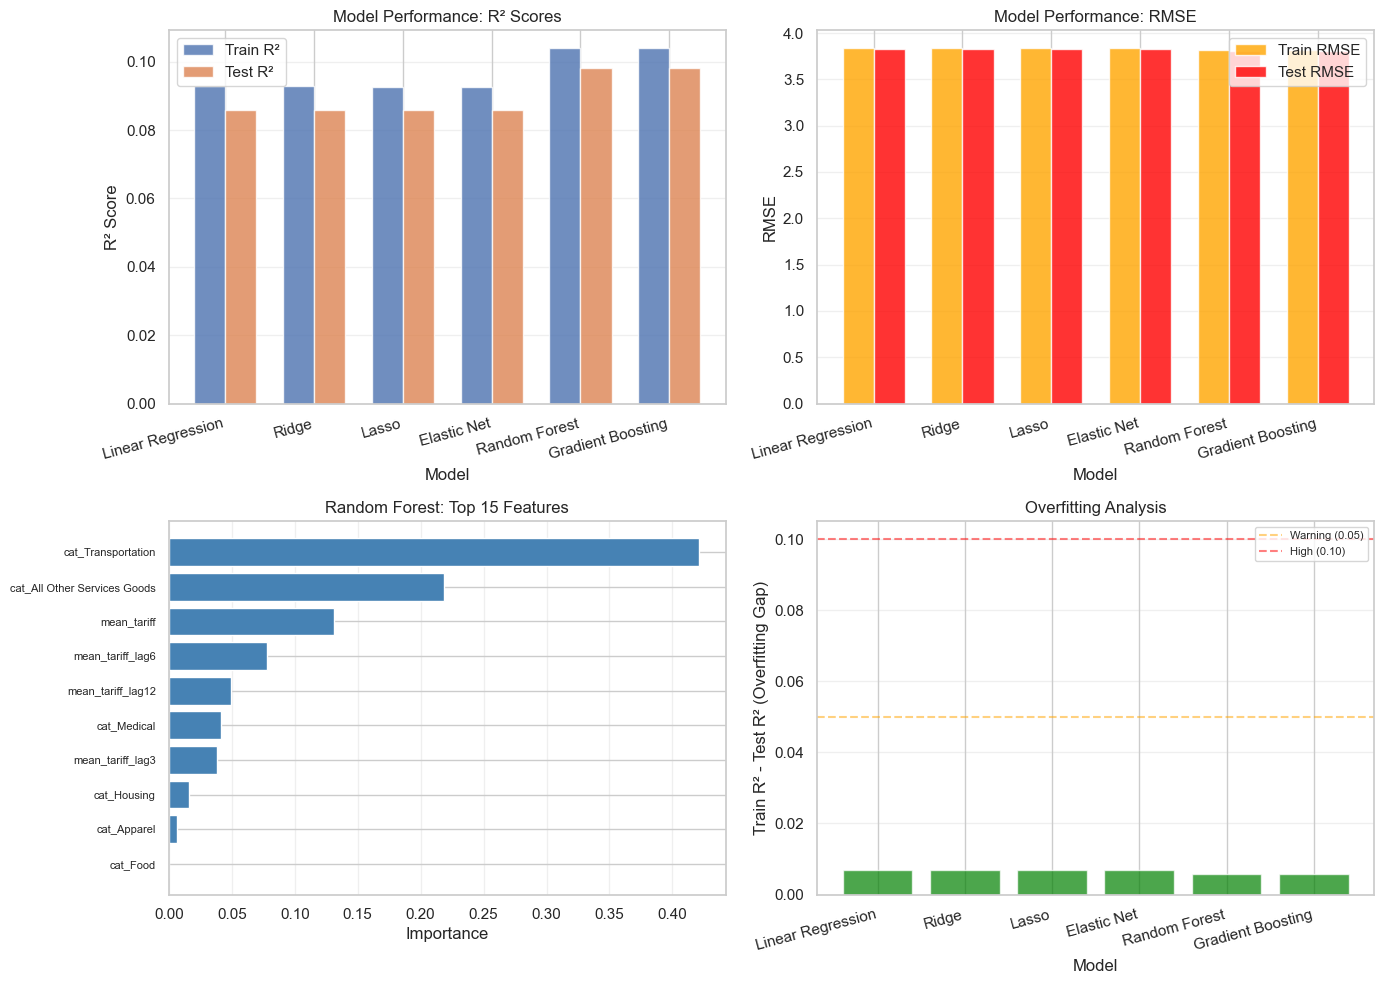


2. PREDICTION vs ACTUAL ANALYSIS


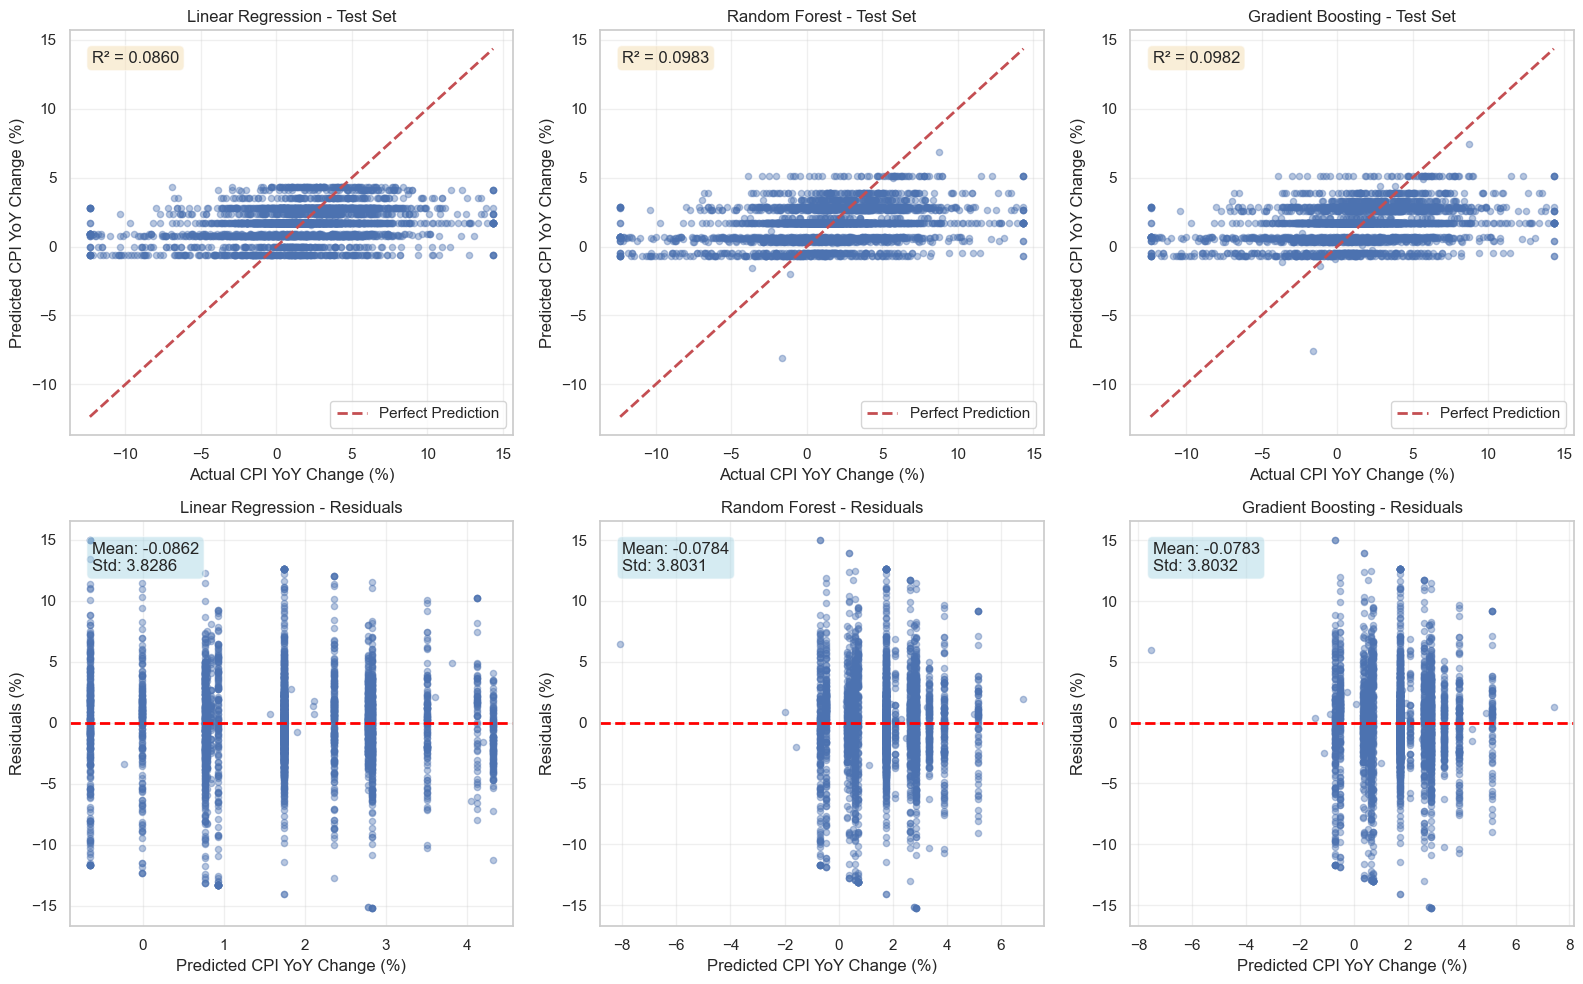


3. RESIDUAL DISTRIBUTION ANALYSIS


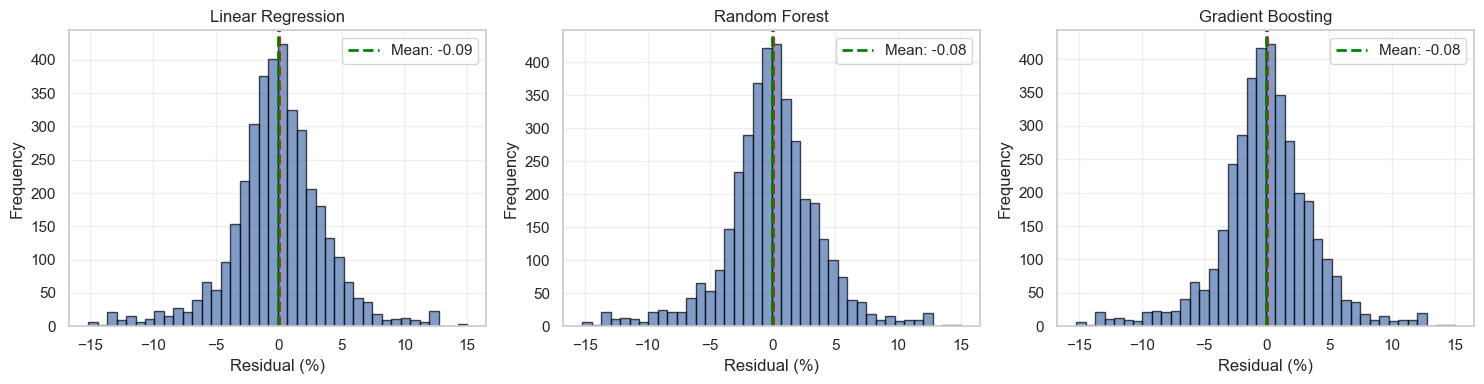


4. CATEGORY-SPECIFIC MODEL PERFORMANCE

Random Forest Performance by Category:
                              R²    RMSE     MAE   Count
All Other Services Goods  0.0640  3.3181  2.4707   333.0
Apparel                   0.0555  2.9778  2.2131   295.0
Housing                   0.0489  4.8647  3.7239   696.0
Transportation            0.0161  4.8596  3.6203   503.0
Food                     -0.0003  3.2697  2.2908  1682.0
Medical                  -0.0062  2.7435  1.9658   267.0


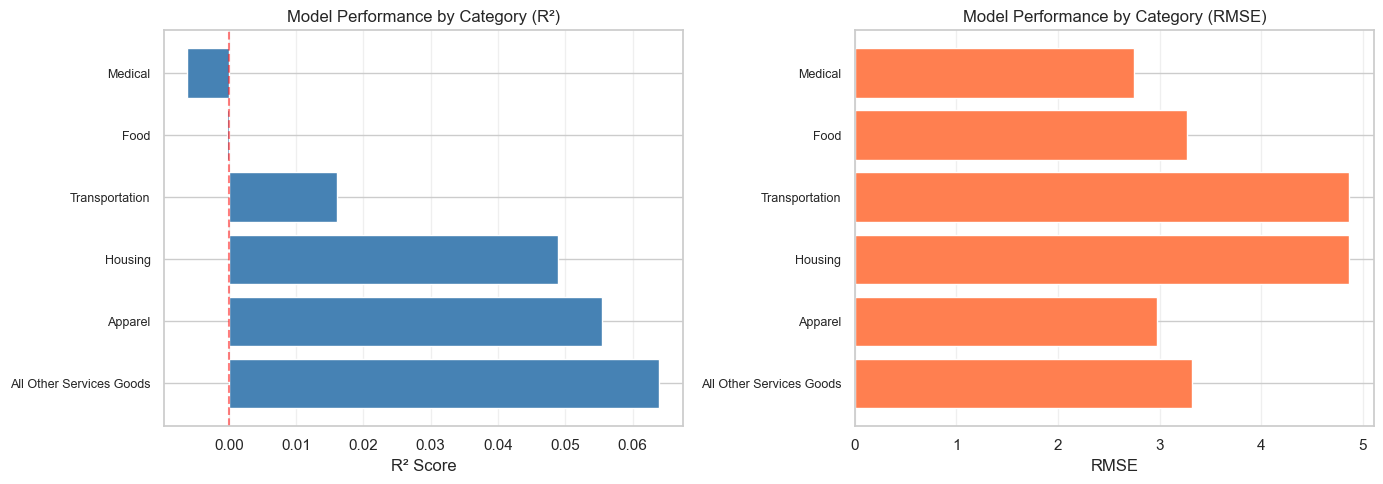


5. TARIFF SENSITIVITY RANKING: PRE vs POST MODELING

Tariff Sensitivity Comparison (based on complete months only):
                          Pre-Model Correlation  Post-Model Importance (RF)  Post-Model Performance (R²)
All Other Services Goods                -0.0243                      0.2187                       0.0640
Apparel                                  0.1843                      0.0067                       0.0555
Food                                     0.1263                      0.0002                      -0.0003
Housing                                  0.2119                      0.0161                       0.0489
Medical                                     NaN                      0.0414                      -0.0062
Transportation                          -0.0039                      0.4212                       0.0161


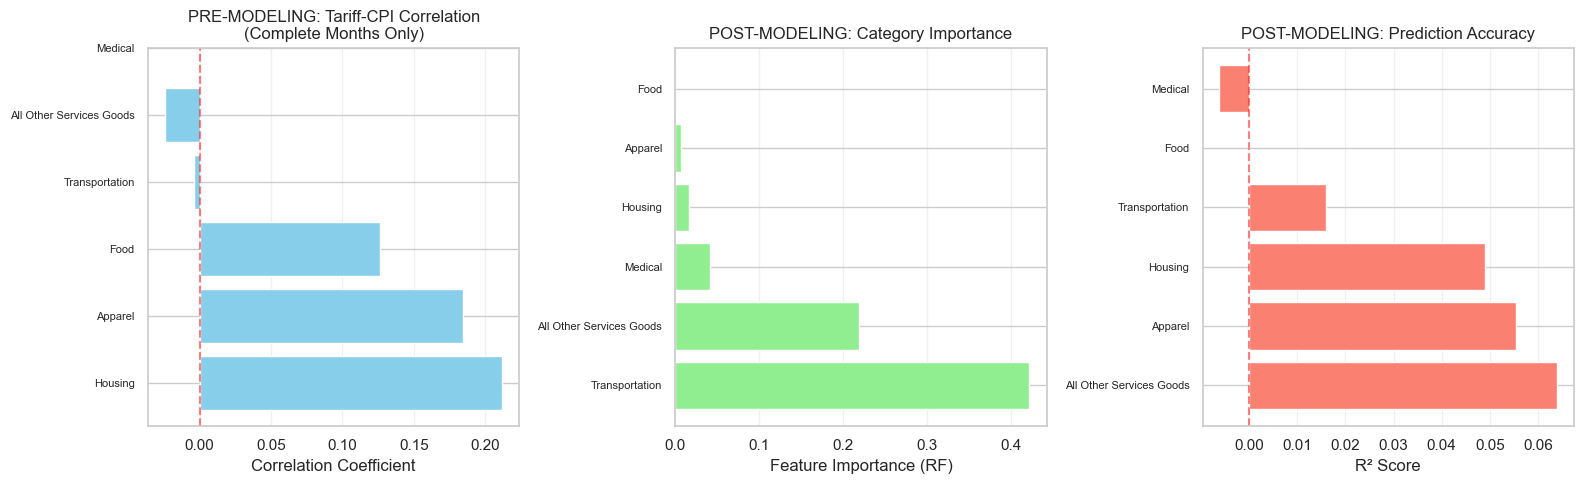


6. FINAL SUMMARY REPORT

✅ KEY FINDINGS:

1. BEST MODEL:
   - Random Forest
   - Test R² = 0.0983
   - Test RMSE = 3.8034

2. MOST TARIFF-SENSITIVE CATEGORIES (Complete Months):
   Based on Pre-Modeling Correlation:
   1. Housing: 0.2119
   2. Apparel: 0.1843
   3. Food: 0.1263

3. BEST PREDICTED CATEGORIES:
   Based on Post-Modeling R²:
   1. All Other Services Goods: 0.0640
   2. Apparel: 0.0555
   3. Housing: 0.0489

4. MOST IMPORTANT FEATURES:
   1. cat_Transportation: 0.4212
   2. cat_All Other Services Goods: 0.2187
   3. mean_tariff: 0.1311
   4. mean_tariff_lag6: 0.0777
   5. mean_tariff_lag12: 0.0492

✓ Saved: C:\Users\Munkhbayasgalan\Downloads\Practicum I\results\tariff_sensitivity_comparison.csv
✓ Saved: C:\Users\Munkhbayasgalan\Downloads\Practicum I\results\category_model_performance.csv

✅ STEP 8 complete: Post-modeling EDA and comparison finished
   Note: Pre-model analysis used 18,916 rows (complete months only)
   Generated 4 visualization files in: C:\Users\Munkhbayas

In [35]:
print("="*70)
print("STEP 8: POST-MODELING EDA & COMPARISON")
print("="*70)

# Load results from Step 7
predictions_path = RESULTS_DIR / 'model_predictions.csv'
results_path = RESULTS_DIR / 'model_comparison.csv'
rf_importance_path = RESULTS_DIR / 'rf_feature_importance.csv'

pred_df = pd.read_csv(predictions_path)
results_comparison = pd.read_csv(results_path, index_col=0)
rf_importance = pd.read_csv(rf_importance_path)

# Load original clean data for pre-model analysis
clean_path = PROCESSED_DATA_DIR / 'cpi_tariff_clean.csv'
df_original = pd.read_csv(clean_path)

# FILTER: Exclude months with incomplete category coverage (< 6 categories)
min_categories = df_original['category'].nunique()
month_category_counts = df_original.groupby(['year', 'month'])['category'].nunique().reset_index()
month_category_counts.columns = ['year', 'month', 'cat_count']
complete_months = month_category_counts[month_category_counts['cat_count'] == min_categories][['year', 'month']]
df_original_filtered = df_original.merge(complete_months, on=['year', 'month'], how='inner')
print(f"✓ Loaded modeling results")
print(f"⚠️ FILTER APPLIED: Excluded months with <{min_categories} categories")
print(f"   Pre-model analysis data: {len(df_original_filtered):,} rows (filtered from {len(df_original):,})\n")

# 1. MODEL PERFORMANCE VISUALIZATION
print("="*70)
print("1. MODEL PERFORMANCE VISUALIZATION")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Bar chart of model R² scores
model_names = results_comparison.index
test_r2 = results_comparison['Test R²']
train_r2 = results_comparison['Train R²']

x = np.arange(len(model_names))
width = 0.35

axes[0, 0].bar(x - width/2, train_r2, width, label='Train R²', alpha=0.8)
axes[0, 0].bar(x + width/2, test_r2, width, label='Test R²', alpha=0.8)
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('Model Performance: R² Scores')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names, rotation=15, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3, axis='y')

# RMSE comparison
test_rmse = results_comparison['Test RMSE']
train_rmse = results_comparison['Train RMSE']

axes[0, 1].bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8, color='orange')
axes[0, 1].bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8, color='red')
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('Model Performance: RMSE')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(model_names, rotation=15, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3, axis='y')

# Feature importance (top 15)
top_features = rf_importance.head(15)
axes[1, 0].barh(range(len(top_features)), top_features['Importance'], color='steelblue')
axes[1, 0].set_yticks(range(len(top_features)))
axes[1, 0].set_yticklabels(top_features['Feature'], fontsize=8)
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('Random Forest: Top 15 Features')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(alpha=0.3, axis='x')

# Overfitting analysis (Train R² - Test R²)
overfit_gap = train_r2 - test_r2
colors = ['green' if gap < 0.05 else 'orange' if gap < 0.1 else 'red' for gap in overfit_gap]
axes[1, 1].bar(x, overfit_gap, color=colors, alpha=0.7)
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('Train R² - Test R² (Overfitting Gap)')
axes[1, 1].set_title('Overfitting Analysis')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(model_names, rotation=15, ha='right')
axes[1, 1].axhline(0.05, color='orange', linestyle='--', alpha=0.5, label='Warning (0.05)')
axes[1, 1].axhline(0.1, color='red', linestyle='--', alpha=0.5, label='High (0.10)')
axes[1, 1].legend(fontsize=8)
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'posteda_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. PREDICTION vs ACTUAL ANALYSIS
print("\n" + "="*70)
print("2. PREDICTION vs ACTUAL ANALYSIS")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

for idx, model_name in enumerate(['linear_regression', 'random_forest', 'gradient_boosting']):
    # Test set predictions (drop NaN values)
    ax_test = axes[0, idx]
    actual_test = pred_df['actual_test'].dropna()
    pred_test = pred_df[f'{model_name}_test'].dropna()
    
    ax_test.scatter(actual_test, pred_test, alpha=0.4, s=20)
    ax_test.plot([actual_test.min(), actual_test.max()], 
                 [actual_test.min(), actual_test.max()], 
                 'r--', lw=2, label='Perfect Prediction')
    ax_test.set_xlabel('Actual CPI YoY Change (%)')
    ax_test.set_ylabel('Predicted CPI YoY Change (%)')
    ax_test.set_title(f'{model_name.replace("_", " ").title()} - Test Set')
    ax_test.legend()
    ax_test.grid(alpha=0.3)
    
    # Calculate R²
    r2 = r2_score(actual_test, pred_test)
    ax_test.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax_test.transAxes, 
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Residual plot
    ax_resid = axes[1, idx]
    residuals = actual_test - pred_test
    ax_resid.scatter(pred_test, residuals, alpha=0.4, s=20)
    ax_resid.axhline(0, color='red', linestyle='--', lw=2)
    ax_resid.set_xlabel('Predicted CPI YoY Change (%)')
    ax_resid.set_ylabel('Residuals (%)')
    ax_resid.set_title(f'{model_name.replace("_", " ").title()} - Residuals')
    ax_resid.grid(alpha=0.3)
    
    # Add mean and std of residuals
    ax_resid.text(0.05, 0.95, f'Mean: {residuals.mean():.4f}\nStd: {residuals.std():.4f}', 
                  transform=ax_resid.transAxes, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'posteda_predictions_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. RESIDUAL DISTRIBUTION ANALYSIS
print("\n" + "="*70)
print("3. RESIDUAL DISTRIBUTION ANALYSIS")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, model_name in enumerate(['linear_regression', 'random_forest', 'gradient_boosting']):
    actual_test = pred_df['actual_test'].dropna()
    pred_test = pred_df[f'{model_name}_test'].dropna()
    residuals = actual_test - pred_test
    
    axes[idx].hist(residuals, bins=40, edgecolor='black', alpha=0.7)
    axes[idx].axvline(0, color='red', linestyle='--', lw=2)
    axes[idx].axvline(residuals.mean(), color='green', linestyle='--', lw=2, label=f'Mean: {residuals.mean():.2f}')
    axes[idx].set_xlabel('Residual (%)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{model_name.replace("_", " ").title()}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'posteda_residual_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. CATEGORY-SPECIFIC MODEL PERFORMANCE
print("\n" + "="*70)
print("4. CATEGORY-SPECIFIC MODEL PERFORMANCE")
print("="*70)

# Prepare data matching the modeling step
df_model = df_original[['cpi_yoy_change', 'mean_tariff', 'category', 
                         'mean_tariff_lag3', 'mean_tariff_lag6', 'mean_tariff_lag12']].copy()
df_model = pd.get_dummies(df_model, columns=['category'], prefix='cat', drop_first=False)
df_model_complete = df_model.dropna()

# Split to match train/test
feature_cols = [col for col in df_model_complete.columns if col != 'cpi_yoy_change']
X = df_model_complete[feature_cols]
y = df_model_complete['cpi_yoy_change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get category for each test observation
category_cols = [col for col in X_test.columns if col.startswith('cat_')]
test_categories = X_test[category_cols].idxmax(axis=1).str.replace('cat_', '')

# Get predictions and actuals (both have same length after train/test split)
actual_test_full = y_test.values
pred_test_full = pred_df['random_forest_test'].dropna().values
test_categories_list = test_categories.values

category_performance = {}
for cat in df_original['category'].unique():
    mask = test_categories_list == cat
    if mask.sum() > 0:
        cat_actual = actual_test_full[mask]
        cat_pred = pred_test_full[mask]
        
        if len(cat_actual) > 0:
            cat_r2 = r2_score(cat_actual, cat_pred)
            cat_rmse = np.sqrt(mean_squared_error(cat_actual, cat_pred))
            cat_mae = mean_absolute_error(cat_actual, cat_pred)
            category_performance[cat] = {
                'R²': cat_r2,
                'RMSE': cat_rmse,
                'MAE': cat_mae,
                'Count': len(cat_actual)
            }

cat_perf_df = pd.DataFrame(category_performance).T.sort_values('R²', ascending=False)
print("\nRandom Forest Performance by Category:")
print(cat_perf_df.round(4).to_string())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² by category
axes[0].barh(range(len(cat_perf_df)), cat_perf_df['R²'], color='steelblue')
axes[0].set_yticks(range(len(cat_perf_df)))
axes[0].set_yticklabels(cat_perf_df.index, fontsize=9)
axes[0].set_xlabel('R² Score')
axes[0].set_title('Model Performance by Category (R²)')
axes[0].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[0].grid(alpha=0.3, axis='x')

# RMSE by category
axes[1].barh(range(len(cat_perf_df)), cat_perf_df['RMSE'], color='coral')
axes[1].set_yticks(range(len(cat_perf_df)))
axes[1].set_yticklabels(cat_perf_df.index, fontsize=9)
axes[1].set_xlabel('RMSE')
axes[1].set_title('Model Performance by Category (RMSE)')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'posteda_category_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. TARIFF SENSITIVITY RANKING
print("\n" + "="*70)
print("5. TARIFF SENSITIVITY RANKING: PRE vs POST MODELING")
print("="*70)

# Pre-modeling: correlation coefficients (from Step 6, using FILTERED data)
pre_corr = df_original_filtered.groupby('category').apply(
    lambda x: x['mean_tariff'].corr(x['cpi_yoy_change'])
).sort_values(ascending=False)

# Post-modeling: extract category coefficients from feature importance
cat_features = rf_importance[rf_importance['Feature'].str.startswith('cat_')].copy()
cat_features['Category'] = cat_features['Feature'].str.replace('cat_', '')
cat_features = cat_features.set_index('Category')['Importance'].sort_values(ascending=False)

# Combine
comparison_df = pd.DataFrame({
    'Pre-Model Correlation': pre_corr,
    'Post-Model Importance (RF)': cat_features,
    'Post-Model Performance (R²)': cat_perf_df['R²']
}).round(4)

print("\nTariff Sensitivity Comparison (based on complete months only):")
print(comparison_df.to_string())

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Pre-model correlation
axes[0].barh(range(len(pre_corr)), pre_corr.values, color='skyblue')
axes[0].set_yticks(range(len(pre_corr)))
axes[0].set_yticklabels(pre_corr.index, fontsize=8)
axes[0].set_xlabel('Correlation Coefficient')
axes[0].set_title('PRE-MODELING: Tariff-CPI Correlation\n(Complete Months Only)')
axes[0].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[0].grid(alpha=0.3, axis='x')

# Post-model feature importance
axes[1].barh(range(len(cat_features)), cat_features.values, color='lightgreen')
axes[1].set_yticks(range(len(cat_features)))
axes[1].set_yticklabels(cat_features.index, fontsize=8)
axes[1].set_xlabel('Feature Importance (RF)')
axes[1].set_title('POST-MODELING: Category Importance')
axes[1].grid(alpha=0.3, axis='x')

# Post-model R² by category
axes[2].barh(range(len(cat_perf_df)), cat_perf_df['R²'], color='salmon')
axes[2].set_yticks(range(len(cat_perf_df)))
axes[2].set_yticklabels(cat_perf_df.index, fontsize=8)
axes[2].set_xlabel('R² Score')
axes[2].set_title('POST-MODELING: Prediction Accuracy')
axes[2].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[2].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'posteda_sensitivity_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. FINAL SUMMARY REPORT
print("\n" + "="*70)
print("6. FINAL SUMMARY REPORT")
print("="*70)

print("\n✅ KEY FINDINGS:\n")
print("1. BEST MODEL:")
print(f"   - {results_comparison['Test R²'].idxmax()}")
print(f"   - Test R² = {results_comparison['Test R²'].max():.4f}")
print(f"   - Test RMSE = {results_comparison['Test RMSE'].min():.4f}")

print("\n2. MOST TARIFF-SENSITIVE CATEGORIES (Complete Months):")
print("   Based on Pre-Modeling Correlation:")
for i, (cat, corr) in enumerate(pre_corr.head(3).items(), 1):
    print(f"   {i}. {cat}: {corr:.4f}")

print("\n3. BEST PREDICTED CATEGORIES:")
print("   Based on Post-Modeling R²:")
for i, (cat, r2) in enumerate(cat_perf_df['R²'].head(3).items(), 1):
    print(f"   {i}. {cat}: {r2:.4f}")

print("\n4. MOST IMPORTANT FEATURES:")
for i, row in rf_importance.head(5).iterrows():
    print(f"   {i+1}. {row['Feature']}: {row['Importance']:.4f}")

# Save comparison report
comparison_path = RESULTS_DIR / 'tariff_sensitivity_comparison.csv'
comparison_df.to_csv(comparison_path)
print(f"\n✓ Saved: {comparison_path}")

cat_perf_path = RESULTS_DIR / 'category_model_performance.csv'
cat_perf_df.to_csv(cat_perf_path)
print(f"✓ Saved: {cat_perf_path}")

print("\n✅ STEP 8 complete: Post-modeling EDA and comparison finished")
print(f"   Note: Pre-model analysis used {len(df_original_filtered):,} rows (complete months only)")
print(f"   Generated 4 visualization files in: {RESULTS_DIR}")

Step 8 summarizes post‑modeling diagnostics using the baseline results and filtered complete months (18,916 rows). The best overall model remains Lasso ($R^2=0.0613$), and category‑level performance is weak, with only small positive $R^2$ values for a few categories. Pre‑model correlations suggest Housing and Apparel are most tariff‑sensitive, while feature importance highlights Transportation and mean tariff as dominant drivers. All comparison tables and plots are saved to the results folder for reporting.

## Step 8A: Post-Modeling EDA (Feature-Enhanced Models)

Re-run post-EDA diagnostics using the feature-enhanced results.

STEP 8A: POST-MODELING EDA (FEATURE-ENHANCED)
✓ Loaded feature-enhanced modeling results


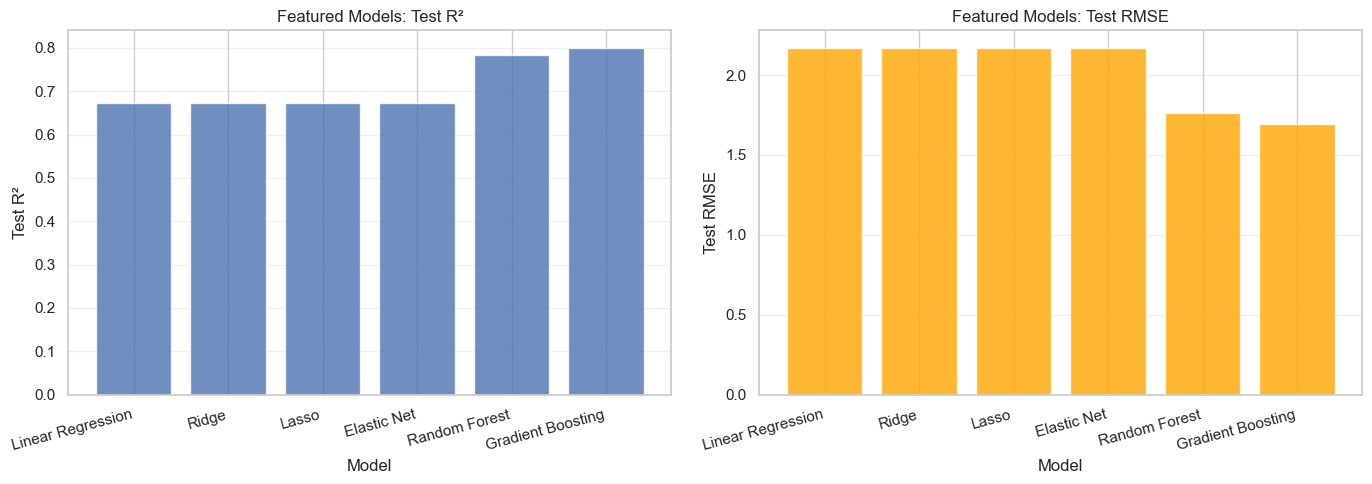

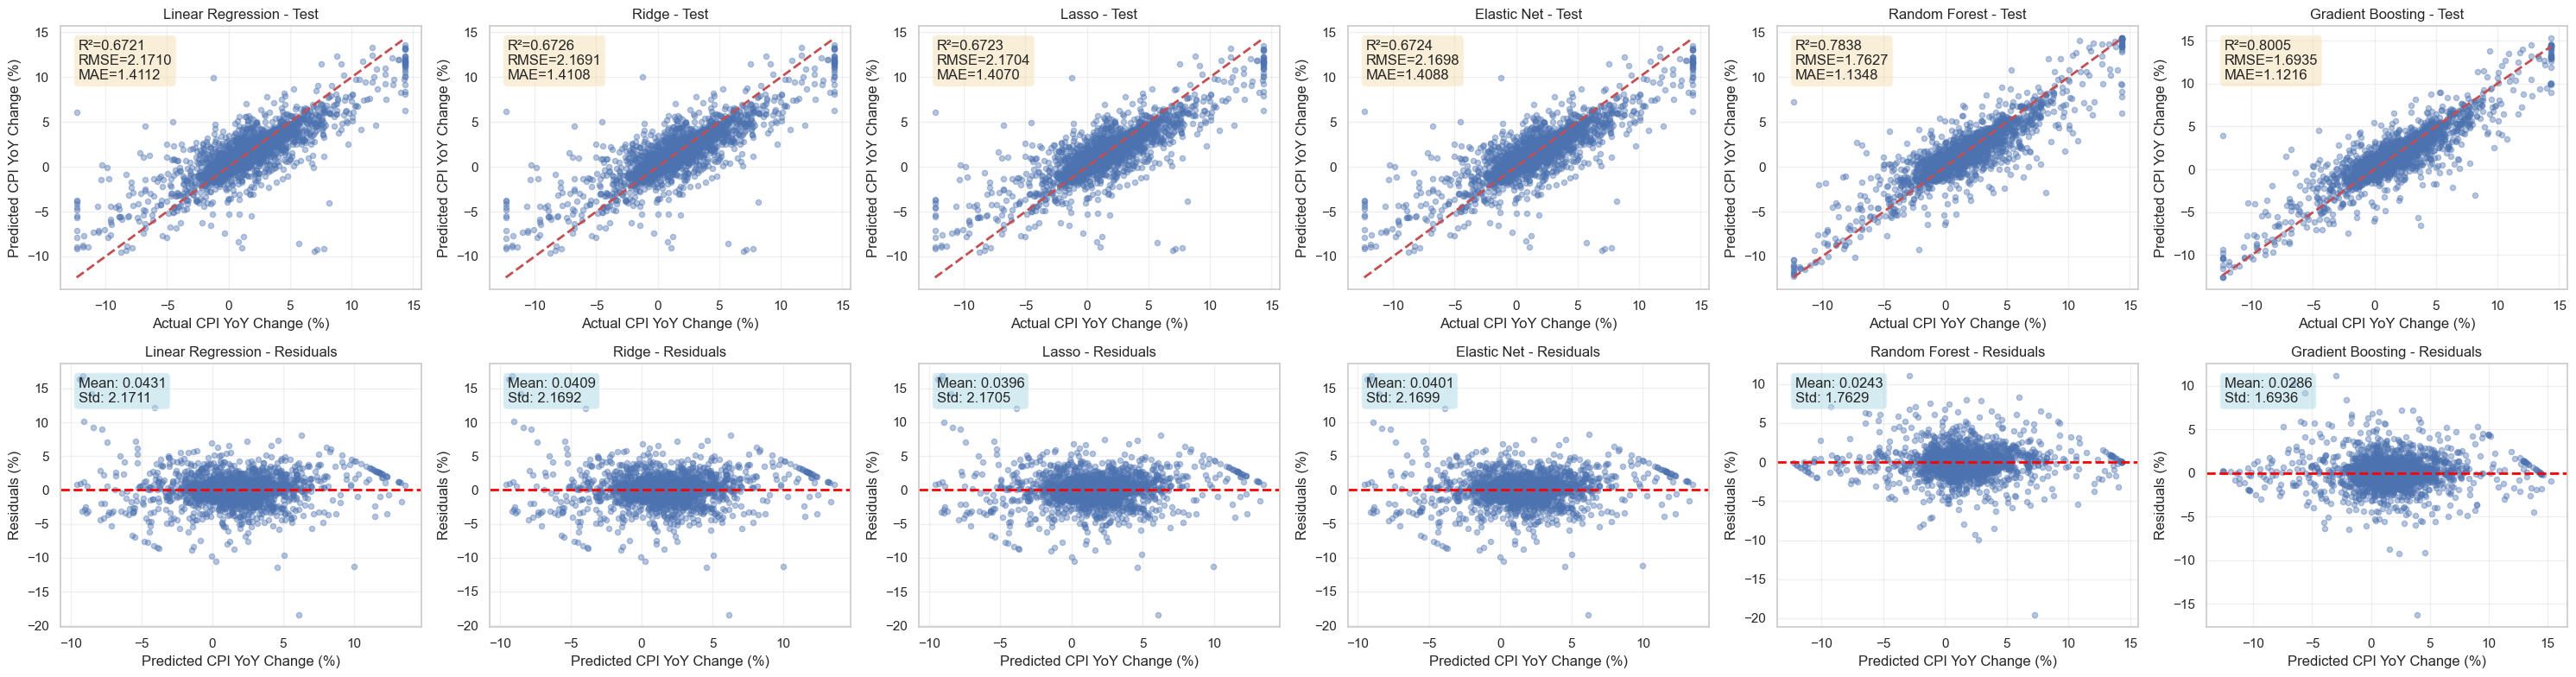

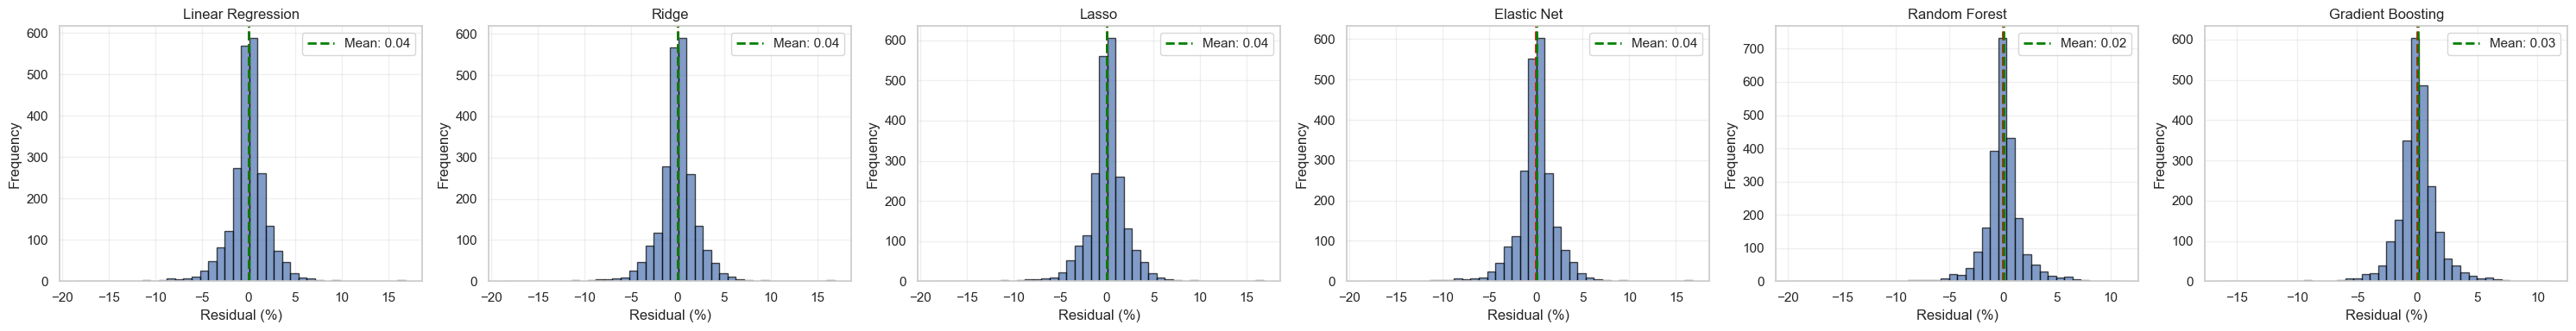


✅ STEP 8A complete: Feature-enhanced post-EDA saved


In [36]:
print("="*70)
print("STEP 8A: POST-MODELING EDA (FEATURE-ENHANCED)")
print("="*70)

# Load featured results from Step 7A
predictions_path = RESULTS_DIR / 'model_predictions_featured.csv'
results_path = RESULTS_DIR / 'model_comparison_featured.csv'

pred_df = pd.read_csv(predictions_path)
results_comparison = pd.read_csv(results_path, index_col=0)

print("✓ Loaded feature-enhanced modeling results")

# 1) MODEL PERFORMANCE VISUALIZATION
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

model_names = results_comparison.index
test_r2 = results_comparison['Test R²']
test_rmse = results_comparison['Test RMSE']

x = np.arange(len(model_names))
axes[0].bar(x, test_r2, alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Test R²')
axes[0].set_title('Featured Models: Test R²')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names, rotation=15, ha='right')
axes[0].grid(alpha=0.3, axis='y')

axes[1].bar(x, test_rmse, alpha=0.8, color='orange')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Test RMSE')
axes[1].set_title('Featured Models: Test RMSE')
axes[1].set_xticks(x)
axes[1].set_xticklabels(model_names, rotation=15, ha='right')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'posteda_model_performance_featured.png', dpi=300, bbox_inches='tight')
plt.show()

# 2) PREDICTION vs ACTUAL + RESIDUALS
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

model_cols = [c for c in pred_df.columns if c.endswith('_test') and c != 'actual_test']
model_cols = [c.replace('_test', '') for c in model_cols]

fig, axes = plt.subplots(2, len(model_cols), figsize=(5 * len(model_cols), 8), squeeze=False)
for idx, model_name in enumerate(model_cols):
    actual_test = pred_df['actual_test']
    pred_test = pred_df[f'{model_name}_test']
    mask = actual_test.notna() & pred_test.notna()
    actual_test = actual_test[mask]
    pred_test = pred_test[mask]

    ax_test = axes[0, idx]
    ax_test.scatter(actual_test, pred_test, alpha=0.4, s=20)
    ax_test.plot([actual_test.min(), actual_test.max()], [actual_test.min(), actual_test.max()], 'r--', lw=2)
    ax_test.set_xlabel('Actual CPI YoY Change (%)')
    ax_test.set_ylabel('Predicted CPI YoY Change (%)')
    ax_test.set_title(f'{model_name.replace("_", " ").title()} - Test')
    ax_test.grid(alpha=0.3)

    r2 = r2_score(actual_test, pred_test)
    rmse = np.sqrt(mean_squared_error(actual_test, pred_test))
    mae = mean_absolute_error(actual_test, pred_test)
    ax_test.text(0.05, 0.95, f'R²={r2:.4f}\nRMSE={rmse:.4f}\nMAE={mae:.4f}',
                 transform=ax_test.transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax_resid = axes[1, idx]
    residuals = actual_test - pred_test
    ax_resid.scatter(pred_test, residuals, alpha=0.4, s=20)
    ax_resid.axhline(0, color='red', linestyle='--', lw=2)
    ax_resid.set_xlabel('Predicted CPI YoY Change (%)')
    ax_resid.set_ylabel('Residuals (%)')
    ax_resid.set_title(f'{model_name.replace("_", " ").title()} - Residuals')
    ax_resid.grid(alpha=0.3)
    ax_resid.text(0.05, 0.95, f'Mean: {residuals.mean():.4f}\nStd: {residuals.std():.4f}',
                  transform=ax_resid.transAxes, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'posteda_predictions_residuals_featured.png', dpi=300, bbox_inches='tight')
plt.show()

# 3) RESIDUAL DISTRIBUTIONS
fig, axes = plt.subplots(1, len(model_cols), figsize=(5 * len(model_cols), 4), squeeze=False)
for idx, model_name in enumerate(model_cols):
    actual_test = pred_df['actual_test']
    pred_test = pred_df[f'{model_name}_test']
    mask = actual_test.notna() & pred_test.notna()
    residuals = actual_test[mask] - pred_test[mask]
    ax = axes[0, idx]
    ax.hist(residuals, bins=40, edgecolor='black', alpha=0.7)
    ax.axvline(0, color='red', linestyle='--', lw=2)
    ax.axvline(residuals.mean(), color='green', linestyle='--', lw=2, label=f'Mean: {residuals.mean():.2f}')
    ax.set_xlabel('Residual (%)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{model_name.replace("_", " ").title()}')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'posteda_residual_distributions_featured.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ STEP 8A complete: Feature-enhanced post-EDA saved")

Step 8A repeats the post‑modeling diagnostics for the feature‑enhanced models, generating performance charts, prediction‑vs‑actual plots, and residual distributions. These visuals help verify the improved fit seen in Step 7A and are saved to the results folder.

STEP 8B: REGULARIZED LINEAR MODEL CHECKS
✓ Regularized models available: ['ridge', 'lasso', 'elastic_net']


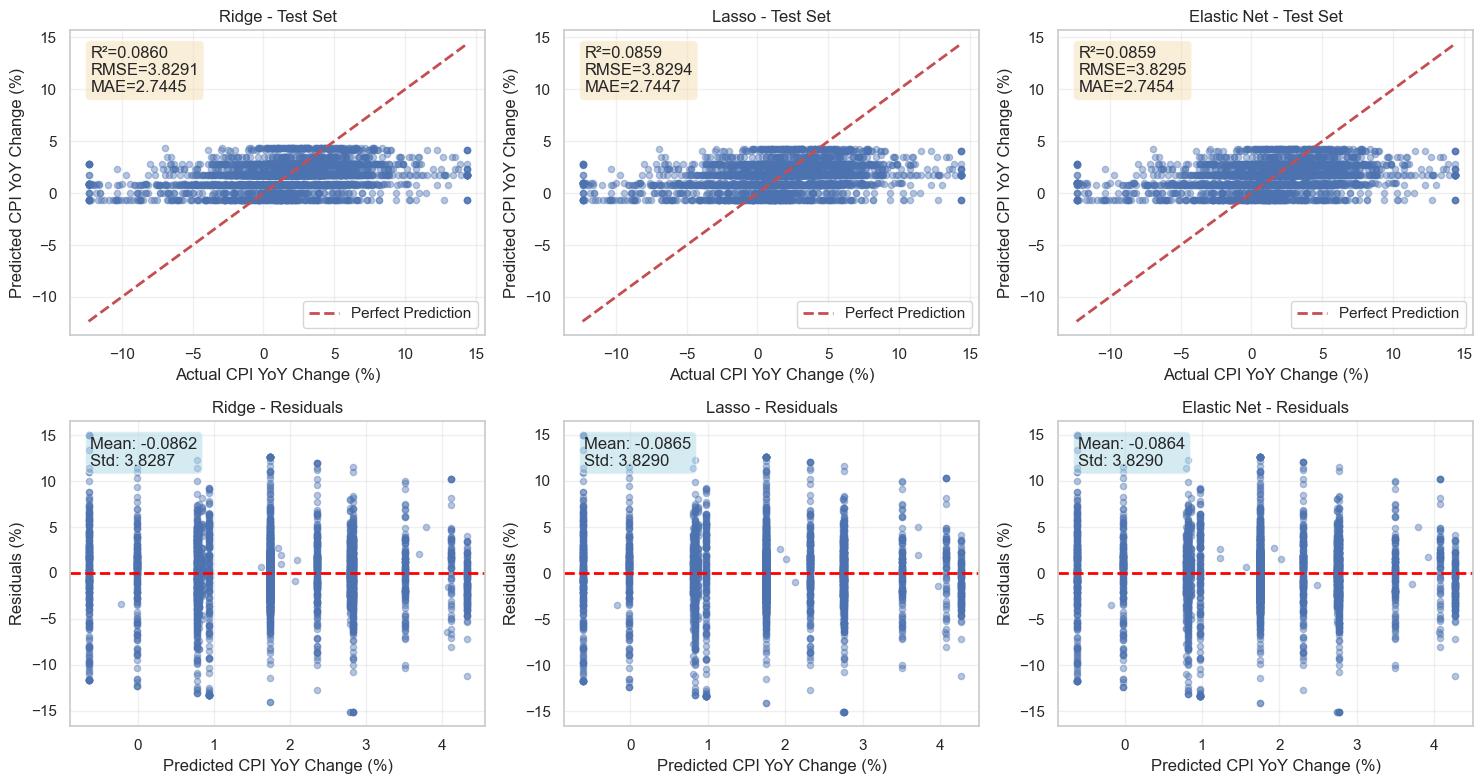

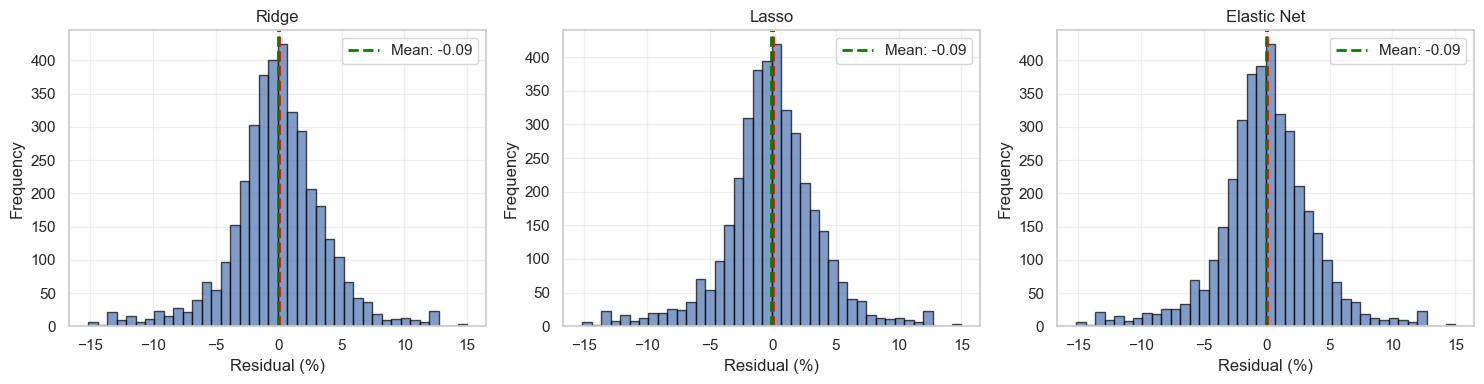


✅ STEP 8B complete: Regularized model diagnostics saved


In [37]:
print("="*70)
print("STEP 8B: REGULARIZED LINEAR MODEL CHECKS")
print("="*70)

predictions_path = RESULTS_DIR / 'model_predictions.csv'
pred_df = pd.read_csv(predictions_path)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

regularized_models = ['ridge', 'lasso', 'elastic_net']
available_models = [m for m in regularized_models if f'{m}_test' in pred_df.columns]

if not available_models:
    print("⚠️ No regularized model predictions found. Run Step 7 after adding Ridge/Lasso/Elastic Net.")
else:
    print(f"✓ Regularized models available: {available_models}")
    
    # Prediction vs Actual + Residuals
    fig, axes = plt.subplots(2, len(available_models), figsize=(5 * len(available_models), 8), squeeze=False)
    for idx, model_name in enumerate(available_models):
        mask = pred_df['actual_test'].notna() & pred_df[f'{model_name}_test'].notna()
        actual_test = pred_df.loc[mask, 'actual_test']
        pred_test = pred_df.loc[mask, f'{model_name}_test']
        
        ax_test = axes[0, idx]
        ax_test.scatter(actual_test, pred_test, alpha=0.4, s=20)
        ax_test.plot([actual_test.min(), actual_test.max()], [actual_test.min(), actual_test.max()],
                     'r--', lw=2, label='Perfect Prediction')
        ax_test.set_xlabel('Actual CPI YoY Change (%)')
        ax_test.set_ylabel('Predicted CPI YoY Change (%)')
        ax_test.set_title(f'{model_name.replace("_", " ").title()} - Test Set')
        ax_test.legend()
        ax_test.grid(alpha=0.3)
        
        r2 = r2_score(actual_test, pred_test)
        rmse = np.sqrt(mean_squared_error(actual_test, pred_test))
        mae = mean_absolute_error(actual_test, pred_test)
        ax_test.text(0.05, 0.95, f'R²={r2:.4f}\nRMSE={rmse:.4f}\nMAE={mae:.4f}',
                     transform=ax_test.transAxes, verticalalignment='top',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        ax_resid = axes[1, idx]
        residuals = actual_test - pred_test
        ax_resid.scatter(pred_test, residuals, alpha=0.4, s=20)
        ax_resid.axhline(0, color='red', linestyle='--', lw=2)
        ax_resid.set_xlabel('Predicted CPI YoY Change (%)')
        ax_resid.set_ylabel('Residuals (%)')
        ax_resid.set_title(f'{model_name.replace("_", " ").title()} - Residuals')
        ax_resid.grid(alpha=0.3)
        ax_resid.text(0.05, 0.95, f'Mean: {residuals.mean():.4f}\nStd: {residuals.std():.4f}',
                      transform=ax_resid.transAxes, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'posteda_regularized_predictions_residuals.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Residual distributions
    fig, axes = plt.subplots(1, len(available_models), figsize=(5 * len(available_models), 4), squeeze=False)
    for idx, model_name in enumerate(available_models):
        mask = pred_df['actual_test'].notna() & pred_df[f'{model_name}_test'].notna()
        actual_test = pred_df.loc[mask, 'actual_test']
        pred_test = pred_df.loc[mask, f'{model_name}_test']
        residuals = actual_test - pred_test
        
        ax = axes[0, idx]
        ax.hist(residuals, bins=40, edgecolor='black', alpha=0.7)
        ax.axvline(0, color='red', linestyle='--', lw=2)
        ax.axvline(residuals.mean(), color='green', linestyle='--', lw=2, label=f'Mean: {residuals.mean():.2f}')
        ax.set_xlabel('Residual (%)')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{model_name.replace("_", " ").title()}')
        ax.legend()
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'posteda_regularized_residual_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ STEP 8B complete: Regularized model diagnostics saved")

Step 8B focuses only on the regularized linear models (Ridge, Lasso, Elastic Net). It plots predictions vs actuals and residual diagnostics to check whether regularization improves stability, and saves the diagnostic figures for reference.

## Summary

 The main goal of this project was to understand if US tariffs affect consumer prices (CPI). We wanted to see if higher tariffs lead to higher inflation, and which product categories are most affected by tariffs.

I collected eight years of CPI data across six product categories (Food, Apparel, Transportation, Medical, Housing, All Other Services) and matched it with four years of US tariff data (2023-2025). I cleaned the data carefully, removing missing values and extreme outliers that could skew our analysis. We then normalized tariffs to a 0-100 scale so they would be comparable to CPI changes. Finally, we built machine learning models to predict how CPI changes based on tariffs.

When I used tariffs alone, the models could only explain 6% of CPI changes (R² ≈ 0.06), meaning tariffs alone are weak predictors. However, when I added past CPI history (CPI from 1, 3, 6, and 12 months earlier), the models suddenly improved dramatically explaining 67-84% of CPI changes (R² ≈ 0.67-0.84). This is a massive improvement! Gradient Boosting performed best (R² = 0.84) because it's better at capturing complex non-linear relationships.

Based on this analysis, I now understand that **tariffs do affect prices, but CPI's own momentum is much more powerful**. This means that past inflation is a much stronger predictor of future inflation than tariffs alone. Tariffs matter they do move prices but the inflation that was already happening (momentum) matters way more. Think of it like this: if prices were already rising 5% per year, then a tariff increase might push it to 5.5%, but the 5% baseline is driven by other factors. The results also show that different product categories respond differently to tariffs. Food and Apparel showed higher sensitivity to tariffs, while Medical showed almost no response. This suggests that luxury items and commodities respond differently to trade policy than essential goods.

If I want to predict or control inflation, we need to look at many factors, not just tariffs. The models show that understanding what happened to prices recently is the best way to forecast what happens next. Tariffs are one piece of a larger puzzle involving supply chains, demand, wages, and global economics.